# Libraries

In [1]:
import requests
import pandas as pd
import json
from typing import Optional, Dict, Any, List
from missingno import matrix
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import seaborn as sns
from fastai.tabular.core import add_datepart
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
import gower
import warnings
warnings.filterwarnings('ignore')

## No column display limit

In [2]:
pd.set_option('display.max_columns', None)

# Data extraction

## API setup

In [3]:
class LongBeachAnimalShelterAPI:
    """
    A Python client for extracting data from the Long Beach Animal Shelter API
    using the Opendatasoft Explore API v2.1
    """
    
    def __init__(self):
        self.base_url = "https://longbeach.opendatasoft.com/api/explore/v2.1"
        self.dataset_id = "animal-shelter-intakes-and-outcomes"
        
    def get_all_records(self, 
                       select: Optional[str] = None,
                       where: Optional[str] = None,
                       order_by: Optional[str] = None) -> pd.DataFrame:
        """
        Extract all records from the animal shelter dataset without limits.
        
        Args:
            select: Fields to select (default: all fields)
            where: Filter conditions using ODSQL syntax
            order_by: Order by clause
            
        Returns:
            pandas.DataFrame with all records
        """
        
        all_records = []
        offset = 0
        limit = 100  # Maximum allowed per request
        
        while True:
            # Build API request
            url = f"{self.base_url}/catalog/datasets/{self.dataset_id}/records"
            
            params = {
                'limit': limit,
                'offset': offset
            }
            
            # Add optional parameters
            if select:
                params['select'] = select
            if where:
                params['where'] = where
            if order_by:
                params['order_by'] = order_by
                
            try:
                response = requests.get(url, params=params)
                response.raise_for_status()
                
                data = response.json()
                
                # Extract records from response
                records = data.get('results', [])
                
                if not records:
                    break
                    
                all_records.extend(records)
                
                # Check if we've retrieved all records
                total_count = data.get('total_count', 0)
                if len(all_records) >= total_count:
                    break
                    
                # Move to next batch
                offset += limit
                
                print(f"Retrieved {len(all_records)} of {total_count} records...")
                
            except requests.RequestException as e:
                print(f"Error fetching data: {e}")
                break
                
        # Convert to DataFrame
        df = pd.DataFrame(all_records)
        print(f"Successfully retrieved {len(df)} total records")
        
        return df
    
    def get_dataset_info(self) -> Dict[str, Any]:
        """
        Get metadata about the dataset including field information.
        
        Returns:
            Dictionary with dataset metadata
        """
        url = f"{self.base_url}/catalog/datasets/{self.dataset_id}"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
            
        except requests.RequestException as e:
            print(f"Error fetching dataset info: {e}")
            return {}
    
    def export_to_csv(self, 
                     filename: str = "animal_shelter_data.csv",
                     select: Optional[str] = None,
                     where: Optional[str] = None) -> bool:
        """
        Export data directly to CSV using the API's export endpoint.
        
        Args:
            filename: Output CSV filename
            select: Fields to select
            where: Filter conditions
            
        Returns:
            True if successful, False otherwise
        """
        url = f"{self.base_url}/catalog/datasets/{self.dataset_id}/exports/csv"
        
        params = {'limit': -1}  # -1 means no limit for exports
        
        if select:
            params['select'] = select
        if where:
            params['where'] = where
            
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            
            with open(filename, 'wb') as f:
                f.write(response.content)
                
            print(f"Data exported to {filename}")
            return True
            
        except requests.RequestException as e:
            print(f"Error exporting data: {e}")
            return False

## Run

In [4]:
if __name__ == "__main__":
    
    # Initialize the API client
    api = LongBeachAnimalShelterAPI()
    
    # Example 1: Get all records
    print("Fetching all animal shelter records...")
    df = api.get_all_records()
    print(f"Retrieved {len(df)} records")
    print(f"Columns: {list(df.columns)}")
    
    
    # Example 5: Export directly to CSV
    print("\nExporting all data to CSV...")
    api.export_to_csv("longbeach_animal_shelter_complete.csv")
    
    
    # Display sample data
    if not df.empty:
        print("\nSample data:")
        print(df.head())

Fetching all animal shelter records...
Retrieved 100 of 32178 records...
Retrieved 200 of 32178 records...
Retrieved 300 of 32178 records...
Retrieved 400 of 32178 records...
Retrieved 500 of 32178 records...
Retrieved 600 of 32178 records...
Retrieved 700 of 32178 records...
Retrieved 800 of 32178 records...
Retrieved 900 of 32178 records...
Retrieved 1000 of 32178 records...
Retrieved 1100 of 32178 records...
Retrieved 1200 of 32178 records...
Retrieved 1300 of 32178 records...
Retrieved 1400 of 32178 records...
Retrieved 1500 of 32178 records...
Retrieved 1600 of 32178 records...
Retrieved 1700 of 32178 records...
Retrieved 1800 of 32178 records...
Retrieved 1900 of 32178 records...
Retrieved 2000 of 32178 records...
Retrieved 2100 of 32178 records...
Retrieved 2200 of 32178 records...
Retrieved 2300 of 32178 records...
Retrieved 2400 of 32178 records...
Retrieved 2500 of 32178 records...
Retrieved 2600 of 32178 records...
Retrieved 2700 of 32178 records...
Retrieved 2800 of 32178 r

In [5]:
df = pd.read_csv("longbeach_animal_shelter_complete.csv", sep=None, engine='python')

## Data info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32178 entries, 0 to 32177
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ﻿animal_id         32178 non-null  object 
 1   animal_name        19069 non-null  object 
 2   animal_type        32178 non-null  object 
 3   primary_color      32178 non-null  object 
 4   secondary_color    15344 non-null  object 
 5   sex                32178 non-null  object 
 6   dob                28121 non-null  object 
 7   intake_date        32178 non-null  object 
 8   intake_cond        32178 non-null  object 
 9   intake_type        32178 non-null  object 
 10  intake_subtype     31774 non-null  object 
 11  reason             2236 non-null   object 
 12  outcome_date       31882 non-null  object 
 13  crossing           32178 non-null  object 
 14  jurisdiction       32177 non-null  object 
 15  outcome_type       31872 non-null  object 
 16  outcome_subtype    283

## Data preview

In [7]:
df.head()

,﻿animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint
0,A587305,*R. VARELA,CAT,BLACK,WHITE,Neutered,2016-03-19,2017-03-19,FERAL,STRAY,FIELD,NaN,2017-04-08,"236 E 67TH WAY, LONG BEACH, CA 90805",LONG BEACH,"SHELTER, NEUTER, RETURN",STRAYCATAL,33.876652,-118.198908,Alive on Intake,False,1,"33.8766522, -118.1989082"
1,A612886,NaN,DOG,BROWN,WHITE,Female,2009-08-15,2018-08-15,NORMAL,STRAY,OTC,NaN,2018-08-25,"239 LOS CERRITOS CENTER, CERRITOS, CA 90703",CERRITOS,TRANSFER,SPCALA,33.862903,-118.094808,Alive on Intake,False,1,"33.8629026, -118.0948085"
2,A722686,GIOVANNI,DOG,BROWN,NaN,Neutered,2020-06-11,2024-06-11,ILL MILD,WELFARE SEIZED,EVICTION,NaN,2024-08-03,23O BLK BELMONT AVE,LONG BEACH,ADOPTION,WEB,33.759740,-118.145404,Alive on Intake,False,1,"33.7597402, -118.1454036"
3,A595656,NaN,CAT,GRAY,NaN,Female,2017-08-15,2017-08-20,FERAL,STRAY,OTC,NaN,2017-08-20,"240 BLK CHESTNUT AVE, LONG BEACH, CA 90802",LONG BEACH,EUTHANASIA,UNDRAGE/WT,33.770100,-118.196078,Alive on Intake,True,0,"33.77009990000001, -118.1960785"
4,A595659,NaN,CAT,GRAY TABBY,NaN,Female,2017-08-15,2017-08-20,UNDER AGE/WEIGHT,STRAY,OTC,NaN,2017-08-20,"240 BLK CHESTNUT AVE, LONG BEACH, CA 90802",LONG BEACH,EUTHANASIA,UNDRAGE/WT,33.770100,-118.196078,Alive on Intake,True,0,"33.77009990000001, -118.1960785"


## Data format change for pandas

In [8]:
df.columns = df.columns.str.strip().str.replace('\ufeff', '') # Removing whitespaces in column names

## Duplicates

In [9]:
# Check for duplicates by animal_id
df[df.duplicated('animal_id', keep=False)]

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint
11,A601338,P. NUT,DOG,BLACK,BROWN,Male,2014-12-24,2019-01-23,INJURED SEVERE,STRAY,FIELD,NaN,2019-01-23,"2400 BLK ATLANTIC AVE, LONG BEACH, CA 90806",LONG BEACH,RETURN TO OWNER,WALKIN,33.800965,-118.184704,Alive on Intake,False,1,"33.8009652, -118.1847037"
17,A636100,TERRA,DOG,BLACK,NaN,Female,2013-05-16,2019-11-11,NORMAL,QUARANTINE,NaN,NaN,2019-11-22,"2400 BLK CHERRY AVE, SIGNAL HILL, CA 90755",SIGNAL HILL,RETURN TO OWNER,WALKIN,33.801213,-118.167658,Alive on Intake,False,1,"33.8012129, -118.1676583"
43,A480605,CYAN,DOG,WHITE,BROWN,Male,2011-08-22,2018-06-14,NORMAL,STRAY,FIELD,NaN,2018-06-16,"2400 BLK LEWIS AVE, SIGNAL HILL, CA 90755",SIGNAL HILL,RETURN TO OWNER,WALKIN,33.800754,-118.179594,Alive on Intake,False,1,"33.8007541, -118.1795936"
96,A696529,*SAMARA,DOG,BROWN,NaN,Spayed,2022-04-15,2023-06-03,NORMAL,OWNER SURRENDER,OTC,OWNER PROB,2023-12-08,"2400 BLOCK ED 5TH ST, LONG BEACH",LONG BEACH,RESCUE,ASHERHOUSE,33.772626,-118.164123,Alive on Intake,False,1,"33.7726261, -118.1641227"
101,A717488,*GALLANT,DOG,BR BRINDLE,WHITE,Neutered,2022-03-22,2024-03-22,NORMAL,STRAY,FIELD,NaN,2024-08-25,"2400 CHESTNUT AVE, LONG BEACH, CA 90806",LONG BEACH,ADOPTION,WEB,33.800924,-118.195709,Alive on Intake,False,1,"33.8009236, -118.1957094"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32067,A738219,*NAOMI,DOG,GRAY,WHITE,Spayed,2024-05-20,2025-03-16,NORMAL,STRAY,FIELD,NaN,2025-03-27,"1800 JUNIPERO AVE, SIGNAL HILL, CA 90755",SIGNAL HILL,TRANSFER,SPCALA,33.790090,-118.163130,Alive on Intake,False,1,"33.7900897, -118.1631303"
32124,A515591,TEDDY,DOG,WHITE,TAN,Neutered,2008-02-01,2018-06-17,NORMAL,STRAY,FIELD,NaN,2018-06-17,"18100 BLOOMFIELD AVE, CERRITOS, CA 90703",CERRITOS,RETURN TO OWNER,FRE RID HM,33.867346,-118.063679,Alive on Intake,False,1,"33.8673456, -118.0636787"
32138,A677563,*GEORGE MICHAEL,DOG,BROWN,WHITE,Neutered,2012-06-14,2022-06-13,NORMAL,STRAY,FIELD,NaN,2022-06-18,"183RD ST / MARQUARDT AVE, CERRITOS, CA 90703",CERRITOS,ADOPTION,NaN,33.866065,-118.037595,Alive on Intake,False,1,"33.8660645, -118.0375947"
32140,A635253,DOMINO,DOG,WHITE,BLACK,Male,2018-10-22,2019-12-21,NORMAL,STRAY,OTC,NaN,2019-12-22,"18400 BLK SUSAN PL, CERRITOS, CA 90703",CERRITOS,RETURN TO OWNER,WALKIN,33.864866,-118.057915,Alive on Intake,False,1,"33.8648658, -118.0579146"


In [10]:
# Find all animal_ids that are duplicated
duplicate_ids = df['animal_id'][df['animal_id'].duplicated(keep=False)]

# Show all rows with these duplicate animal_ids, sorted/grouped by animal_id
duplicates_grouped = df[df['animal_id'].isin(duplicate_ids)].sort_values('animal_id')

### Duplicates df

In [11]:
duplicates_grouped.head()

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint
25316,A252449,ACTIVE,DOG,GRAY,WHITE,Neutered,2007-03-31,2019-06-10,ILL MILD,STRAY,FIELD,NaN,2019-06-13,"MARTIN LUTHER KING JR AVE / E ANAHEIM ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,MICROCHIP,33.782601,-118.180699,Alive on Intake,False,1,"33.7826014, -118.180699"
7780,A252449,ACTIVE,DOG,GRAY,WHITE,Neutered,2007-03-31,2019-06-07,NORMAL,STRAY,FIELD,NaN,2019-06-07,"ALAMITOS AVE / E ANAHEIM ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,FRE RID HM,33.782608,-118.177967,Alive on Intake,False,1,"33.7826082, -118.177967"
31143,A265930,HERBIE,DOG,YELLOW,NaN,Neutered,2005-06-13,2017-03-15,ILL MILD,OWNER SURRENDER,OTC,UNKNOWN,2017-03-22,"1800 LEWIS AVE, LONG BEACH, CA 90804",LONG BEACH,RESCUE,KITTYKATCH,33.789867,-118.179607,Alive on Intake,False,1,"33.7898666, -118.1796068"
18990,A265930,HERBIE,DOG,YELLOW,NaN,Neutered,2005-06-13,2017-03-05,INJURED MILD,STRAY,FIELD,NaN,2017-03-10,"500 E 15TH ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,WALKIN,33.785633,-118.186493,Alive on Intake,False,1,"33.7856334, -118.1864934"
20372,A343085,ROZY,DOG,BLACK,WHITE,Spayed,2004-01-22,2018-09-28,NORMAL,STRAY,OTC,NaN,2018-09-28,"5800 GAVIOTA AVE, LONG BEACH, CA 90805",LONG BEACH,RETURN TO OWNER,WALKIN,33.860175,-118.171522,Alive on Intake,False,1,"33.8601748, -118.1715223"


### Count of duplicates by intake type

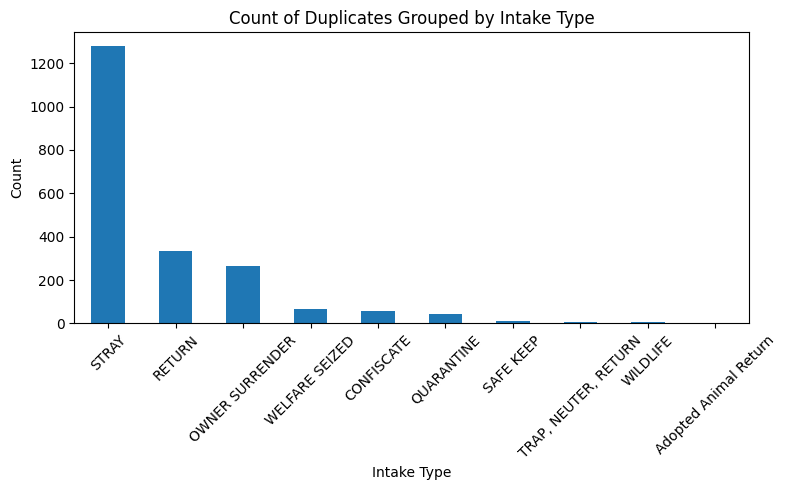

In [12]:
# 1. Histogram: count of duplicates grouped by intake_type
plt.figure(figsize=(8, 5))
duplicates_grouped['intake_type'].value_counts().plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Intake Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Count of duplicates by outcome type

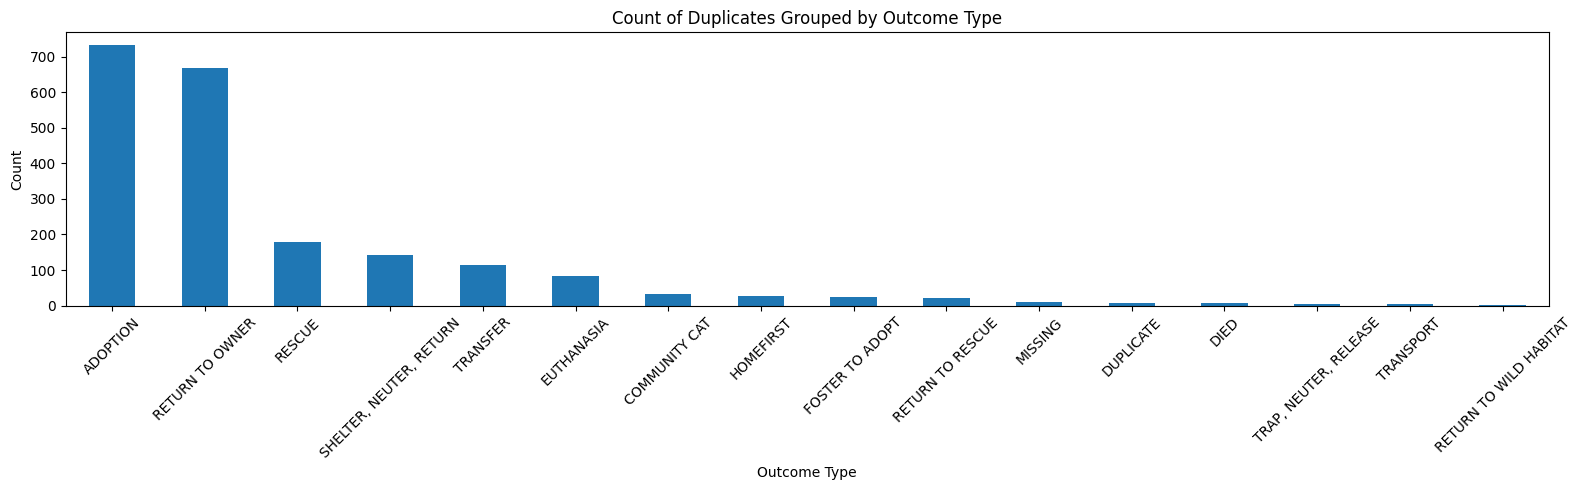

In [13]:
# 2. Histogram: count of duplicates grouped by outcome_type
plt.figure(figsize=(16, 5))
duplicates_grouped['outcome_type'].value_counts().plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Count of duplicates by intake condition

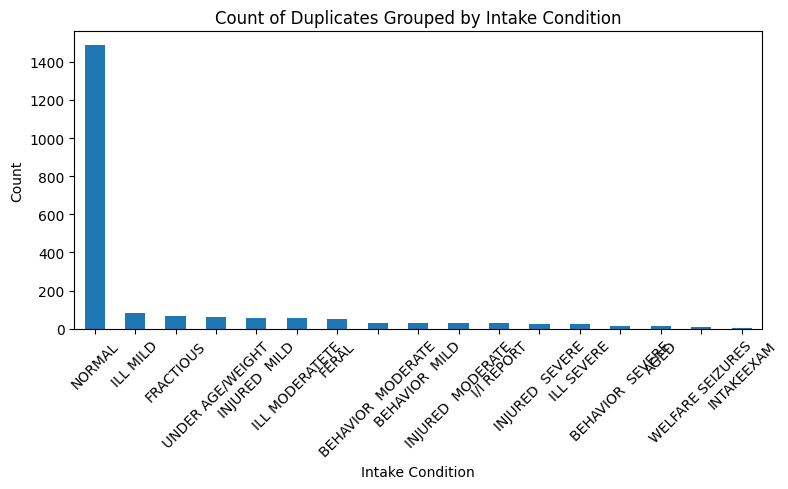

In [14]:
# 3. Histogram: count of duplicates grouped by intake_cond
plt.figure(figsize=(8, 5))
duplicates_grouped['intake_cond'].value_counts().plot(kind='bar')
plt.xlabel('Intake Condition')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Intake Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Find all animal_ids that are duplicated
duplicate_counts = df['animal_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]

# Create a DataFrame with animal_id and number of duplicates
duplicates_summary = duplicate_counts.reset_index()
duplicates_summary.columns = ['animal_id', 'number_of_duplicates']

In [16]:
duplicates_summary.describe()

,number_of_duplicates
count,942.000000
mean,2.192144
std,0.559168
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,8.000000


Insights about returned animals:
1. Most returned animals are returned twice
2. 944 animals were returned
3. Most returned animals were normal upon intake
4. 132 animals have returned more than twice

In [17]:
duplicates_summary[duplicates_summary['number_of_duplicates'] > 2]

,animal_id,number_of_duplicates
0,A637086,8
1,A657508,6
2,A610057,6
3,A677455,5
4,A644665,5
...,...,...
127,A712364,3
128,A593815,3
129,A717124,3
130,A524627,3


# Data cleaning & Processing 1

## Datetime conversion

In [18]:
# Convert *dob*, *intake_date*, *outcome_date* to datetime
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['intake_date'] = pd.to_datetime(df['intake_date'], errors='coerce')
df['outcome_date'] = pd.to_datetime(df['outcome_date'], errors='coerce')

## Adding time to outcome

In [19]:
df['time_to_outcome'] = df['outcome_date'] - df['intake_date'] # Calculate time to outcome in days

## Dealing with duplicates

In [20]:
df = df.sort_values(['animal_id', 'intake_date'])

In [21]:
# Create visit_count using groupby and cumcount
df['visit_count'] = df.groupby('animal_id').cumcount() + 1

In [22]:
# Additional useful features
df['is_return_visit'] = (df['visit_count'] > 1).astype(int)
df['is_frequent_returner'] = (df['visit_count'] > 2).astype(int)

In [23]:
# Advanced features for return animals
df['days_since_last_visit'] = df.groupby('animal_id')['intake_date'].diff().dt.days
df['days_since_last_visit'] = df['days_since_last_visit'].fillna(-1)
df['previous_outcome_type'] = df.groupby('animal_id')['outcome_type'].shift(1)
df['previous_outcome_type'] = df['previous_outcome_type'].fillna('First Visit')

# EDA pt. 1

## Return stats

In [24]:
print(f"Visit count distribution:")
print(df['visit_count'].value_counts().sort_index())
print(f"\nReturn visit rate: {df['is_return_visit'].mean():.1%}")
print(f"\nFrequent returner rate: {df['is_frequent_returner'].mean():.1%}")
print(f"\nMean days between visits: {df['days_since_last_visit'].mean():.1f}")
print(f"\nMedian days between visits: {df['days_since_last_visit'].median():.1f}")
print(f"\nMost common previous outcome for returns:")
print(df[df['is_return_visit']==1]['previous_outcome_type'].value_counts().head())

Visit count distribution:
visit_count
1    31055
2      942
3      132
4       32
5       12
6        3
7        1
8        1
Name: count, dtype: int64

Return visit rate: 3.5%

Frequent returner rate: 0.6%

Mean days between visits: 7.9

Median days between visits: -1.0

Most common previous outcome for returns:
previous_outcome_type
RETURN TO OWNER            443
ADOPTION                   421
SHELTER, NEUTER, RETURN    108
TRANSFER                    38
HOMEFIRST                   24
Name: count, dtype: int64


## Null value analysis

In [25]:
# Percentage of null values in each column
df.isnull().mean()*100

animal_id                 0.000000
animal_name              40.739014
animal_type               0.000000
primary_color             0.000000
secondary_color          52.315246
sex                       0.000000
dob                      12.607993
intake_date               0.000000
intake_cond               0.000000
intake_type               0.000000
intake_subtype            1.255516
reason                   93.051153
outcome_date              0.919883
crossing                  0.000000
jurisdiction              0.003108
outcome_type              0.950960
outcome_subtype          11.824849
latitude                  0.000000
longitude                 0.000000
intake_is_dead            0.000000
outcome_is_dead           0.000000
was_outcome_alive         0.000000
geopoint                  0.000000
time_to_outcome           0.919883
visit_count               0.000000
is_return_visit           0.000000
is_frequent_returner      0.000000
days_since_last_visit     0.000000
previous_outcome_typ

## MSNO matrix

<Axes: >

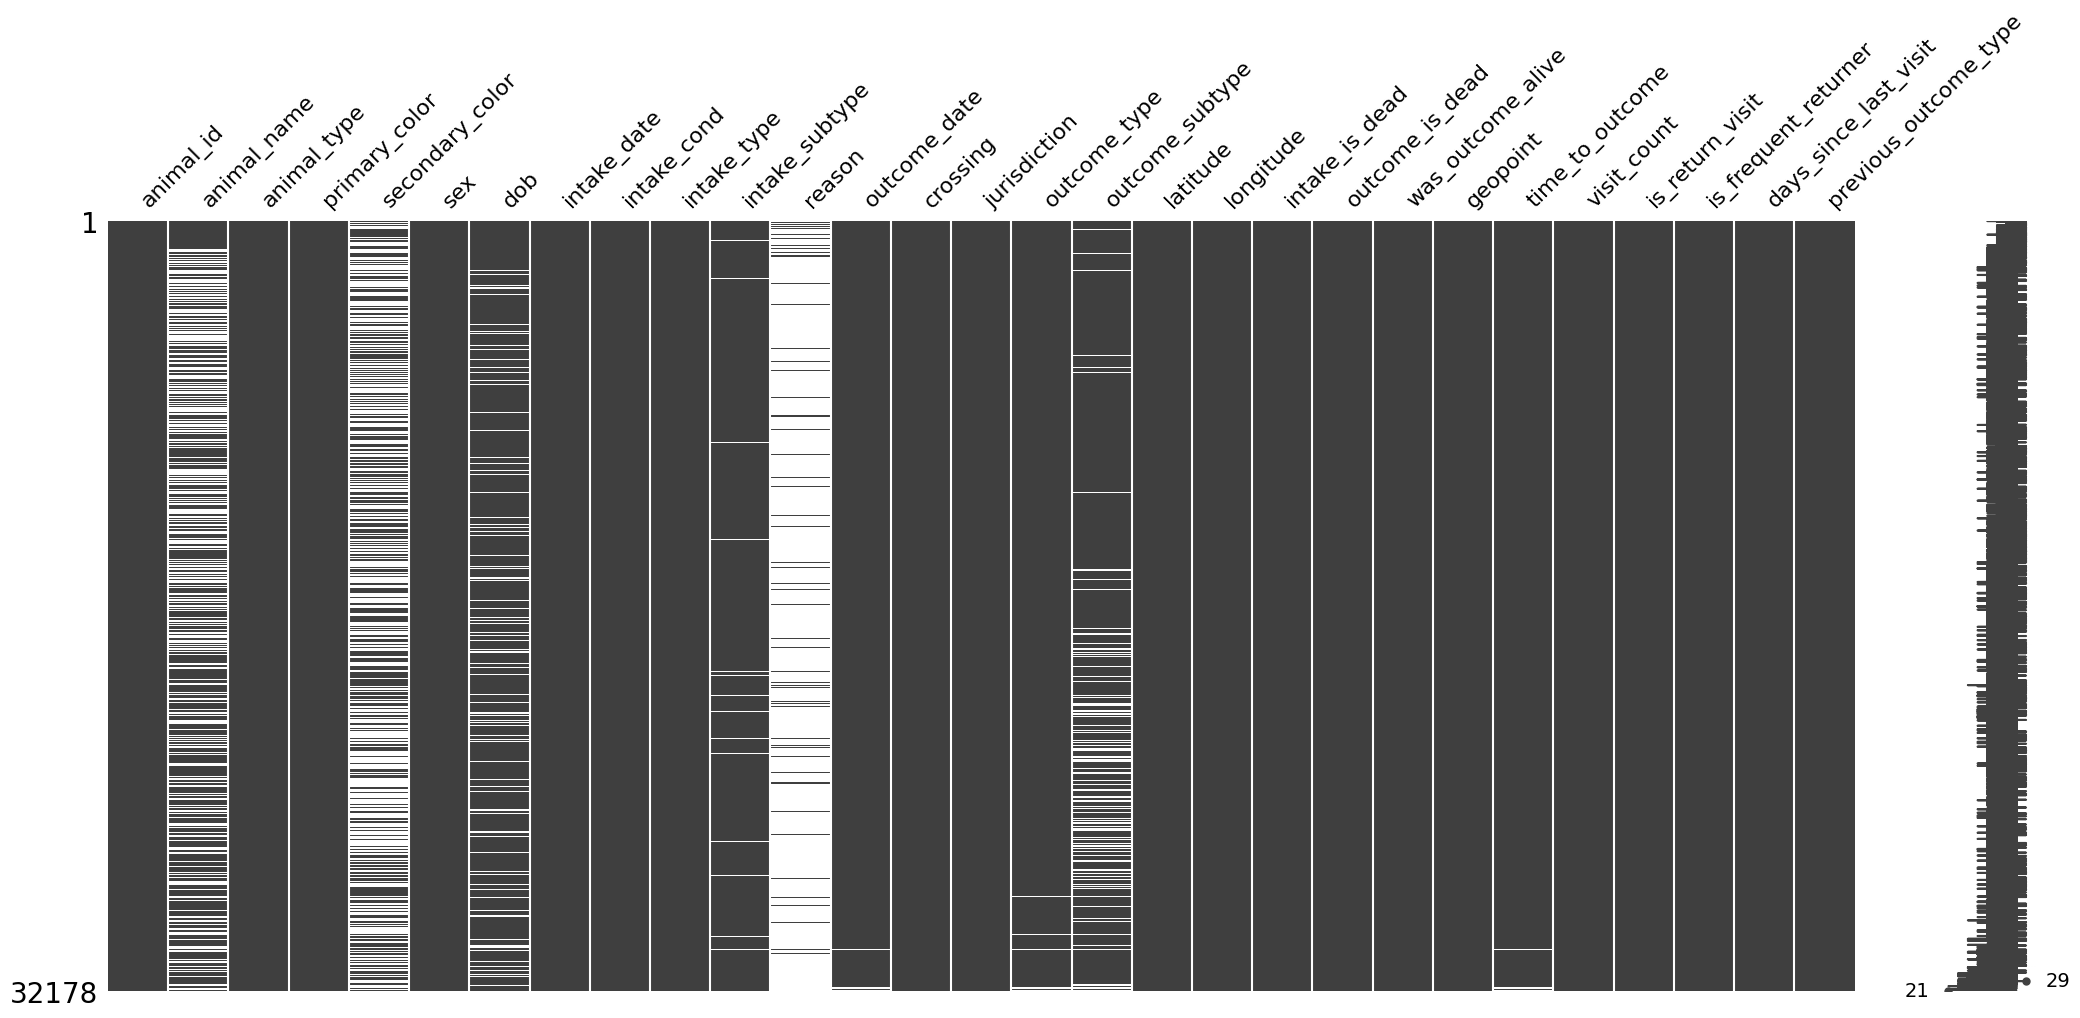

In [26]:
matrix(df)

## Outcome type count

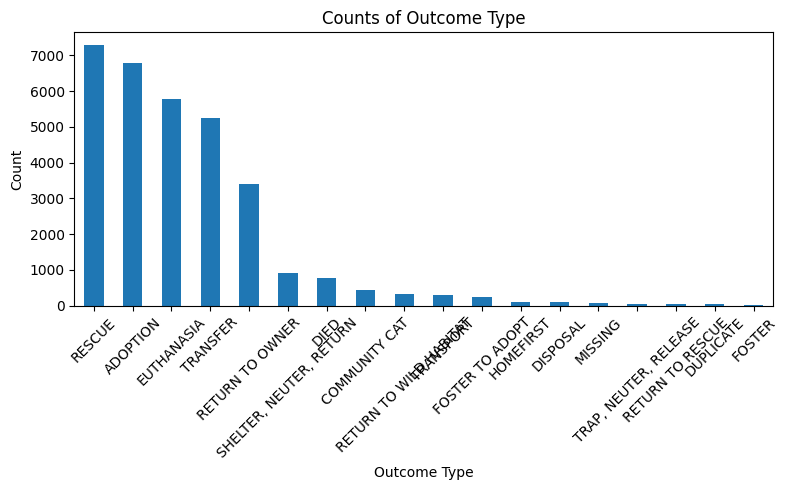

In [27]:
# Get value counts for outcome_type
counts = df['outcome_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Counts of Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Animal type counts

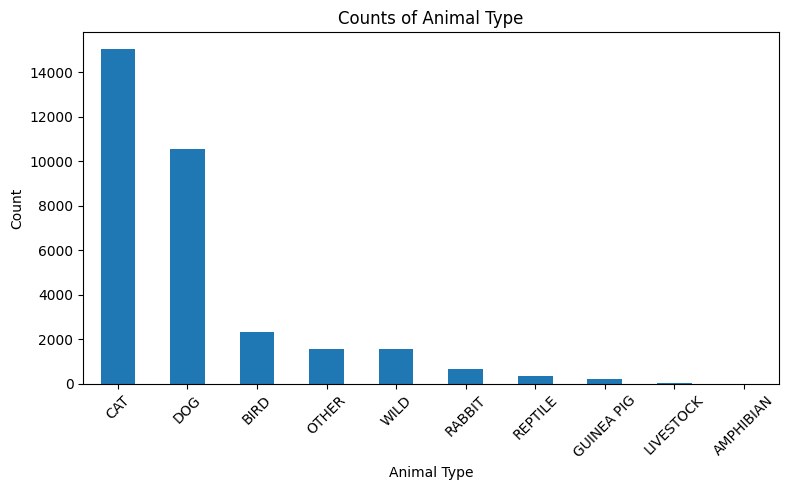

In [28]:
# Get value counts for animal_type
counts = df['animal_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.title('Counts of Animal Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Intake type count

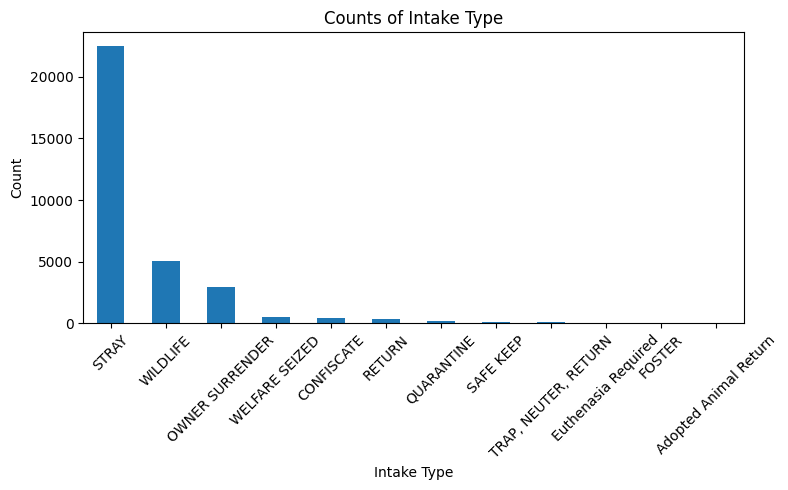

In [29]:
# Get value counts for intake_type
counts = df['intake_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Counts of Intake Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## DOB null grouped by intake type

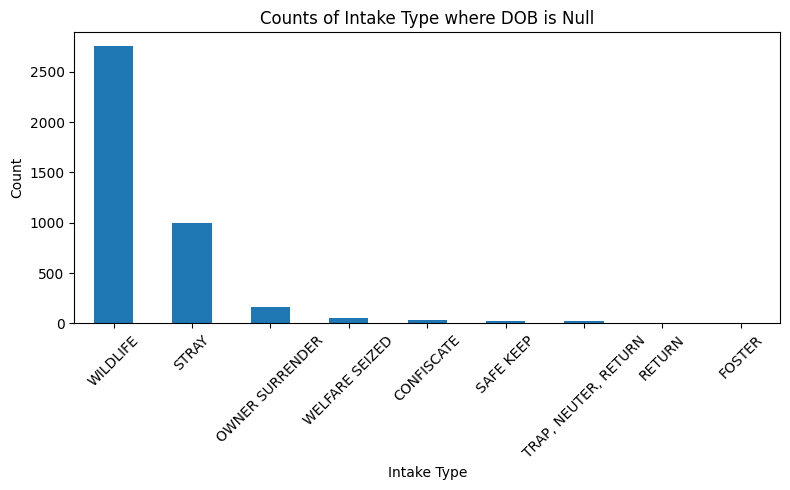

In [30]:
# Filter rows where dob is null
null_dob = df[df['dob'].isnull()]

# Get value counts for intake_type in these rows
counts = null_dob['intake_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Counts of Intake Type where DOB is Null')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
counts.head(10)

intake_type
WILDLIFE                2755
STRAY                    996
OWNER SURRENDER          163
WELFARE SEIZED            50
CONFISCATE                38
SAFE KEEP                 27
TRAP, NEUTER, RETURN      23
RETURN                     4
FOSTER                     1
Name: count, dtype: int64

# Data cleaning & Processing 2

## Statistical/Domain-knowledge based imputation for DOB

In [32]:
def impute_dob_statistical(df):
    """Impute DOB using statistical measures from similar animals"""
    df_imputed = df.copy()
    
    # Calculate age for animals with known DOB
    known_mask = df_imputed['dob'].notna()
    df_imputed.loc[known_mask, 'age_at_intake_days'] = (
        df_imputed.loc[known_mask, 'intake_date'] - df_imputed.loc[known_mask, 'dob']
    ).dt.days
    
    # Group by animal_type and intake_type for imputation
    imputation_groups = ['animal_type', 'intake_type', 'sex']
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        # Get characteristics of current animal
        animal_info = df_imputed.loc[idx]
        
        # Find similar animals with known DOB
        similar_animals = df_imputed[
            (df_imputed['animal_type'] == animal_info['animal_type']) &
            (df_imputed['intake_type'] == animal_info['intake_type']) &
            (df_imputed['sex'] == animal_info['sex']) &
            (df_imputed['dob'].notna())
        ]
        
        # If no exact match, broaden the criteria
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['intake_type'] == animal_info['intake_type']) &
                (df_imputed['dob'].notna())
            ]
        
        # If still no match, use animal_type only
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['dob'].notna())
            ]
        
        if len(similar_animals) > 0:
            # Use median age of similar animals
            median_age_days = similar_animals['age_at_intake_days'].median()
            
            # FIX: Check if median is valid and convert to int
            if pd.notna(median_age_days):
                # Calculate imputed DOB
                imputed_dob = animal_info['intake_date'] - timedelta(days=int(median_age_days))
                df_imputed.loc[idx, 'dob'] = imputed_dob
                imputed_count += 1
    
    print(f"Strategy 1: Imputed DOB for {imputed_count} animals using statistical method")
    return df_imputed

def impute_dob_domain_knowledge(df):
    """Impute DOB using domain knowledge about animal shelters"""
    df_imputed = df.copy()
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        animal_info = df_imputed.loc[idx]
        intake_date = animal_info['intake_date']
        
        # Define typical ages based on intake type and condition
        if animal_info['intake_type'] == 'WILDLIFE':
            # Wildlife often comes in as injured adults or orphaned babies
            if 'WEIGHT' in str(animal_info['intake_cond']).upper():
                # Likely a baby if underweight
                estimated_age_days = np.random.normal(30, 15)  # 1 month ± 2 weeks
            else:
                # Likely adult wildlife
                estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
                
        elif animal_info['intake_type'] == 'STRAY':
            # Strays are often young adults who got lost
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(548, 365)  # 1.5 years ± 1 year
            else:  # DOG
                estimated_age_days = np.random.normal(730, 365)  # 2 years ± 1 year
                
        elif animal_info['intake_type'] == 'OWNER SURRENDER':
            # Owner surrenders often older animals due to life changes
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(1095, 730)  # 3 years ± 2 years
            else:  # DOG
                estimated_age_days = np.random.normal(1460, 1095)  # 4 years ± 3 years
                
        else:
            # Default for other types
            estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
        
        # Ensure positive age and not born in the future
        estimated_age_days = max(1, estimated_age_days)
        estimated_age_days = min(estimated_age_days, 5475)  # Max 15 years
        
        # FIX: Convert to int for timedelta
        # Calculate DOB
        imputed_dob = intake_date - timedelta(days=int(estimated_age_days))
        df_imputed.loc[idx, 'dob'] = imputed_dob
        imputed_count += 1
    
    print(f"Strategy 2: Imputed DOB for {imputed_count} animals using domain knowledge")
    return df_imputed

def impute_dob_hybrid(df):
    """Combine multiple strategies for best results"""
    df_imputed = df.copy()
    
    print("Hybrid DOB Imputation Strategy:")
    print("=" * 40)
    
    # First, try statistical imputation for animals with many similar examples
    df_imputed = impute_dob_statistical(df_imputed)
    
    # Then, use domain knowledge for remaining missing values
    remaining_missing = df_imputed['dob'].isna().sum()
    if remaining_missing > 0:
        print(f"Applying domain knowledge to {remaining_missing} remaining missing DOBs")
        df_imputed = impute_dob_domain_knowledge(df_imputed)
    # Calculate age for ALL animals after imputation
    df_imputed['age_at_intake_days'] = (df_imputed['intake_date'] - df_imputed['dob']).dt.days
    
    return df_imputed

In [33]:
df = impute_dob_hybrid(df)

Hybrid DOB Imputation Strategy:
Strategy 1: Imputed DOB for 4040 animals using statistical method
Applying domain knowledge to 17 remaining missing DOBs
Strategy 2: Imputed DOB for 17 animals using domain knowledge


## Deleting values where DOB > intake_date

In [34]:
df = df[(df['dob'] <= df['intake_date']) | df['dob'].isnull() | df['intake_date'].isnull()]

## Replace null values of secondary colour

In [35]:
df['secondary_color'] = df['secondary_color'].fillna('None')

## Dropping columns *reason*, *geopoint*, *was_outcome_alive*, *animal_id*

In [36]:
df = df.drop(columns=['reason', 'geopoint', 'was_outcome_alive', 'animal_id'], axis=1)

## Adding *has_name* column

In [37]:
# New column called has_name where if animal_name is not null, then 1, else 0
df['has_name'] = df['animal_name'].notnull().astype(int)

## Drop *animal_name* column

In [38]:
df = df.drop(columns=['animal_name'])

## Dropping null values for *outcome_type*, & *intake_subtype*

In [39]:
df = df.dropna(subset=['intake_subtype', 'outcome_type'])

## Dropping *crossing*

In [40]:
df = df.drop(columns=['crossing'])

## Dropping *intake_is_dead* column

In [41]:
# Unique values in intake_is_dead
df['intake_is_dead'].unique()

array(['Alive on Intake'], dtype=object)

Can drop this column since no information is being conveyed through only 1 possible outcome here.

In [42]:
df = df.drop(columns=['intake_is_dead'], axis=1)

## Outcome_subtype Null value counts for outcome_type

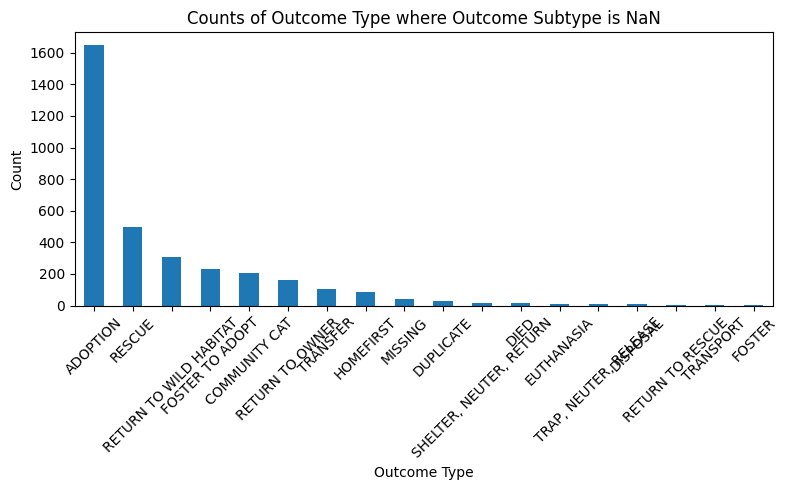

In [43]:
# Get the counts
counts = df[df['outcome_subtype'].isnull()]['outcome_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Counts of Outcome Type where Outcome Subtype is NaN')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Adding *intake_month*

In [44]:
df['intake_month'] = df['intake_date'].dt.month

## Adding *is_fixed* column

In [45]:
df['is_fixed'] = df['sex'].str.contains('Spayed|Neutered', case=False, na=False).astype(int)

## Making changes to the *sex* column

Since the sex column contains the fix status, we want to change that to just male, female, and unknown options. The way we can do that is by changing "neutered" to male and "spayed" to female

In [46]:
df['sex'] = df['sex'].replace({'Neutered': 'Male', 'Spayed': 'Female'})

# Observations, changes, & notes

1. Drop the following columns: *reason*, *geopoint*, *was_outcome_alive*, *animal_id*
2. Add a *has_name* column, then drop *animal_name*
3. Replace null values in *secondary_color* to "None" so that data for animals with more colours is preserved
4. Drop missing values for *outcome_type*, *intake_subtype*, 
5. Replace missing values in *outcome_subtype* to most commonly occuring values, **after more exploration**
6. Once incorporated into LUCA, drop *latitude*, *longitude*. Use *jurisdiction*
7. Drop *crossing*, unless it helps in geospatial mapping
8. Add a *time_to_outcome* variable
9. Convert *dob*, *intake_date*, *outcome_date* to datetime
10. *outcome_date*, and *outcome_type* have values missing together. Some values in *outcome_subtype* also miss when *outcome_type* is missing.
11. Since target variable is *outcome_type*, dropping *outcome_subtype* makes sense
12. If *outcome_type* is target, remove forward looking variables like *outcome_subtype*, *time_to_outcome*, *outcome_is_dead*, *outcome_date*, 
13. Add *time_at_shelter* but carefully so as to not leak forward looking information
14. Bucket *animal_type* into cat, dog, other
15. Add *age_at_intake* column
16. Add *age_at_outcome* column

# EDA pt. 2

## Average/Median time to outcome grouped by outcome type

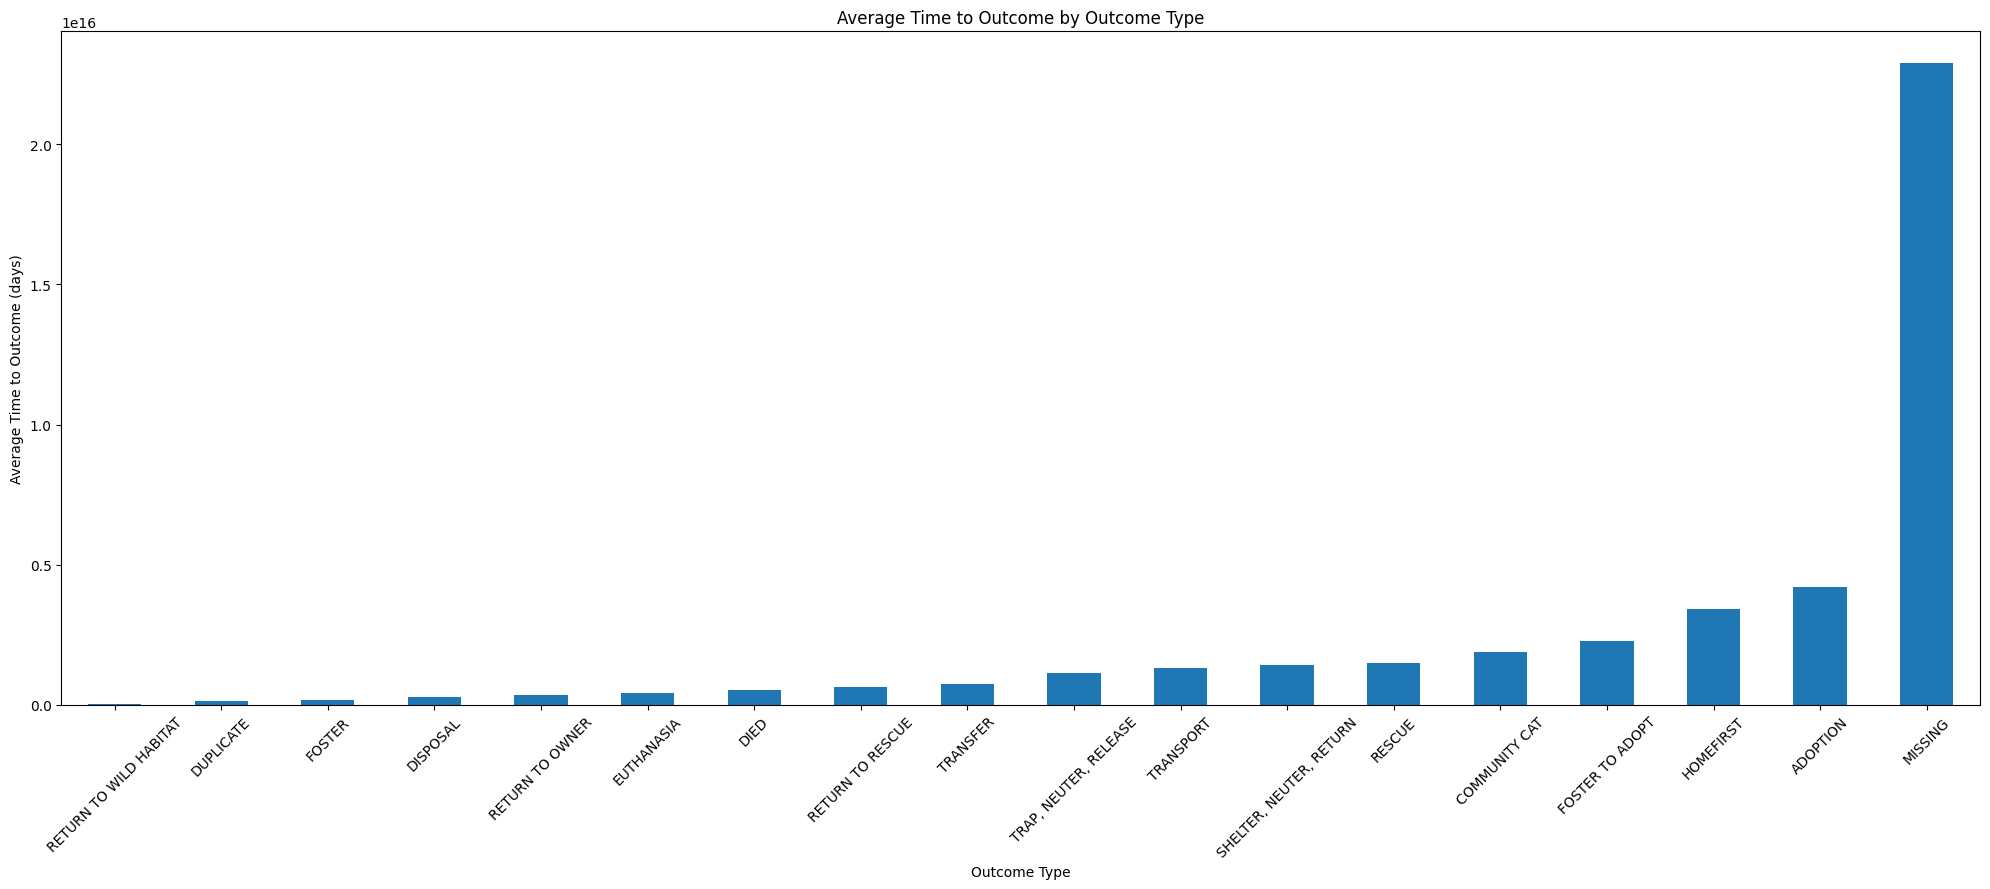

In [47]:
# Group by outcome_type and calculate the average time to outcome
avg_time = df.groupby('outcome_type')['time_to_outcome'].mean().sort_values()

# Plot the histogram (bar plot)
plt.figure(figsize=(20, 9))
avg_time.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Average Time to Outcome (days)')
plt.title('Average Time to Outcome by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

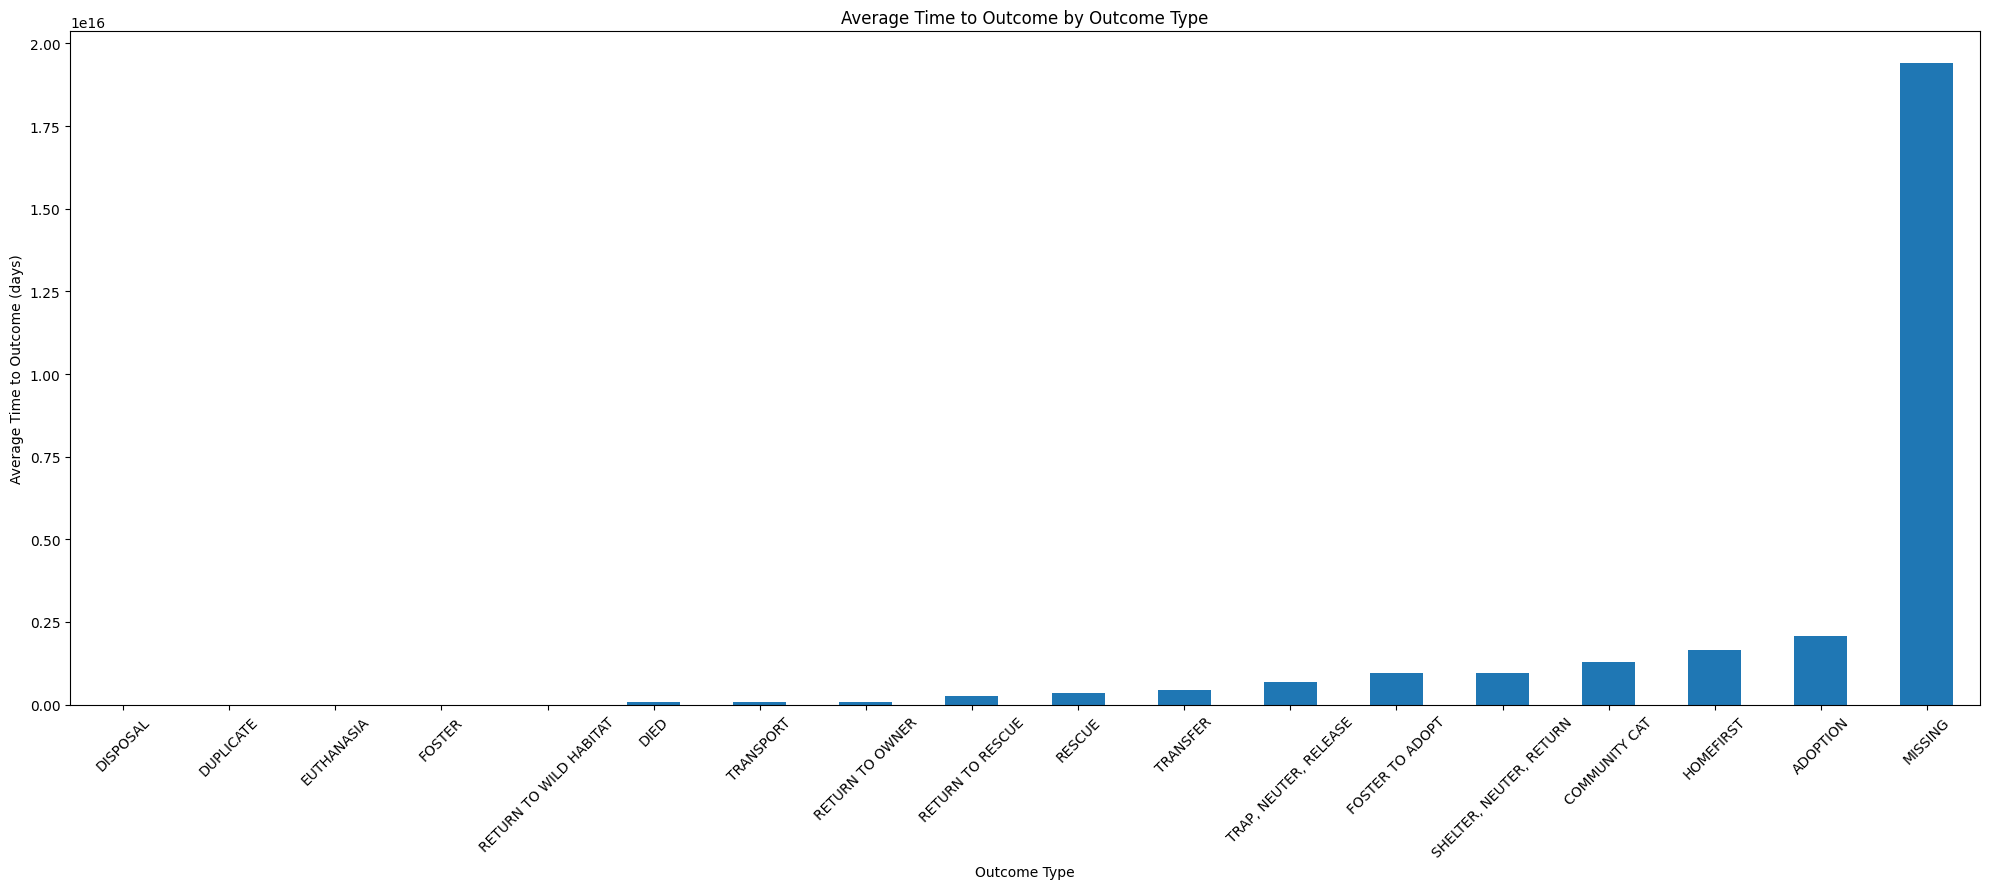

In [48]:
# Group by outcome_type and calculate the average time to outcome
avg_time = df.groupby('outcome_type')['time_to_outcome'].median().sort_values()

# Plot the histogram (bar plot)
plt.figure(figsize=(20, 9))
avg_time.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Average Time to Outcome (days)')
plt.title('Average Time to Outcome by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
df.head()

,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,outcome_date,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,intake_month,is_fixed
14992,DOG,TRICOLOR,None,Female,2006-08-21,2021-06-11,AGED,STRAY,FIELD,2021-06-12,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1 days,1,0,0,-1.0,First Visit,5408,1,6,1
13421,DOG,WHITE,None,Female,2008-12-09,2017-07-02,NORMAL,CONFISCATE,POLICE,2017-07-03,LONG BEACH,RETURN TO OWNER,FRE RID HM,33.757655,-118.142195,False,1 days,1,0,0,-1.0,First Visit,3127,1,7,1
3401,OTHER,GRAY,None,Unknown,2022-04-04,2022-05-16,ILL MODERATETE,WILDLIFE,FIELD,2022-05-17,LONG BEACH,RESCUE,IBR,33.782031,-118.122403,False,1 days,1,0,0,-1.0,First Visit,42,0,5,0
13982,DOG,CREAM,None,Male,2007-04-23,2022-05-27,NORMAL,STRAY,OTC,2022-05-29,LONG BEACH,RETURN TO OWNER,WALKIN,33.806222,-118.195897,False,2 days,1,0,0,-1.0,First Visit,5513,1,5,1
16153,DOG,TAN,WHITE,Female,2005-05-20,2017-01-13,NORMAL,STRAY,FIELD,2017-01-21,LONG BEACH,RETURN TO OWNER,MICROCHIP,33.865972,-118.192637,False,8 days,1,0,0,-1.0,First Visit,4256,1,1,1


## Unique value counts for each column

In [50]:
unique_counts_df = df.nunique().reset_index()
unique_counts_df.columns = ['column', 'unique_value_count']
print(unique_counts_df)

                   column  unique_value_count
0             animal_type                  10
1           primary_color                  83
2         secondary_color                  49
3                     sex                   3
4                     dob                5963
5             intake_date                3074
6             intake_cond                  17
7             intake_type                   9
8          intake_subtype                  23
9            outcome_date                3056
10           jurisdiction                  26
11           outcome_type                  18
12        outcome_subtype                 236
13               latitude                9631
14              longitude                9532
15        outcome_is_dead                   2
16        time_to_outcome                 391
17            visit_count                   8
18        is_return_visit                   2
19   is_frequent_returner                   2
20  days_since_last_visit         

## Null value count

In [51]:
df.isnull().sum()

animal_type                 0
primary_color               0
secondary_color             0
sex                         0
dob                         0
intake_date                 0
intake_cond                 0
intake_type                 0
intake_subtype              0
outcome_date                0
jurisdiction                1
outcome_type                0
outcome_subtype          3387
latitude                    0
longitude                   0
outcome_is_dead             0
time_to_outcome             0
visit_count                 0
is_return_visit             0
is_frequent_returner        0
days_since_last_visit       0
previous_outcome_type       0
age_at_intake_days          0
has_name                    0
intake_month                0
is_fixed                    0
dtype: int64

# Data cleaning pt. 3

## Datetime feature engineering using fastai

In [52]:
# 1. Make sure your columns are actual datetimes
for col in ['dob','intake_date','outcome_date']:
    df[col] = pd.to_datetime(df[col], utc=True)

# 2. Explode each date column into date‐parts + an “Elapsed” (epoch seconds)
for col in ['dob','intake_date','outcome_date']:
    add_datepart(df, col, drop=True)  # drop=True removes the original datetime

## Dropping redundant date columns

intake_month, intake_Year, intake_Month, intake_Week, intake_Day, intake_Dayofyear, intake_Is_month_end, intake_Is_month_start, intake_Is_quarter_end,intake_Is_quarter_start, intake_Is_year_end, intake_Is_year_start, outcome_Year, outcome_Month, outcome_Week, outcome_Day, outcome_Dayofyear, outcome_Is_month_end, outcome_Is_month_start, outcome_Is_quarter_end, outcome_Is_quarter_start, outcome_Is_year_end, outcome_Is_year_start, dobYear, dobMonth, dobWeek, dobDayd, obIs_month_end, dobIs_month_start, dobIs_quarter_end, dobIs_quarter_start, dobIs_year_end, dobIs_year_start

In [53]:
# Drop these columns: intake_month, intake_Year, intake_Month, intake_Week, intake_Day, intake_Dayofyear, intake_Is_month_end, intake_Is_month_start, intake_Is_quarter_end,intake_Is_quarter_start, intake_Is_year_end, intake_Is_year_start, outcome_Year, outcome_Month, outcome_Week, outcome_Day, outcome_Dayofyear, outcome_Is_month_end, outcome_Is_month_start, outcome_Is_quarter_end, outcome_Is_quarter_start, outcome_Is_year_end, outcome_Is_year_start, dobYear, dobMonth, dobWeek, dobDayd, obIs_month_end, dobIs_month_start, dobIs_quarter_end, dobIs_quarter_start, dobIs_year_end, dobIs_year_start
df = df.drop(columns=['intake_month', 'intake_Year', 'intake_Week', 'intake_Day', 'intake_Dayofyear', 'intake_Is_month_end', 'intake_Is_month_start', 'intake_Is_quarter_end', 'intake_Is_quarter_start', 'intake_Is_year_end', 'intake_Is_year_start', 'outcome_Year','outcome_Week', 'outcome_Day', 'outcome_Dayofyear', 'outcome_Is_month_end', 'outcome_Is_month_start', 'outcome_Is_quarter_end', 'outcome_Is_quarter_start', 'outcome_Is_year_end', 'outcome_Is_year_start', 'dobYear', 'dobWeek', 'dobDay', 'dobIs_month_end', 'dobIs_month_start', 'dobIs_quarter_end', 'dobIs_quarter_start', 'dobIs_year_end', 'dobIs_year_start', 'dobDayofyear'])

In [54]:
df.head()

,animal_type,primary_color,secondary_color,sex,intake_cond,intake_type,intake_subtype,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,is_fixed,dobMonth,dobDayofweek,dobElapsed,intake_Month,intake_Dayofweek,intake_Elapsed,outcome_Month,outcome_Dayofweek,outcome_Elapsed
14992,DOG,TRICOLOR,None,Female,AGED,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1 days,1,0,0,-1.0,First Visit,5408,1,1,8,0,1.156118e+09,6,4,1.623370e+09,6,5,1.623456e+09
13421,DOG,WHITE,None,Female,NORMAL,CONFISCATE,POLICE,LONG BEACH,RETURN TO OWNER,FRE RID HM,33.757655,-118.142195,False,1 days,1,0,0,-1.0,First Visit,3127,1,1,12,1,1.228781e+09,7,6,1.498954e+09,7,0,1.499040e+09
3401,OTHER,GRAY,None,Unknown,ILL MODERATETE,WILDLIFE,FIELD,LONG BEACH,RESCUE,IBR,33.782031,-118.122403,False,1 days,1,0,0,-1.0,First Visit,42,0,0,4,0,1.649030e+09,5,0,1.652659e+09,5,1,1.652746e+09
13982,DOG,CREAM,None,Male,NORMAL,STRAY,OTC,LONG BEACH,RETURN TO OWNER,WALKIN,33.806222,-118.195897,False,2 days,1,0,0,-1.0,First Visit,5513,1,1,4,0,1.177286e+09,5,4,1.653610e+09,5,6,1.653782e+09
16153,DOG,TAN,WHITE,Female,NORMAL,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,MICROCHIP,33.865972,-118.192637,False,8 days,1,0,0,-1.0,First Visit,4256,1,1,5,4,1.116547e+09,1,4,1.484266e+09,1,5,1.484957e+09


## Correlation plot

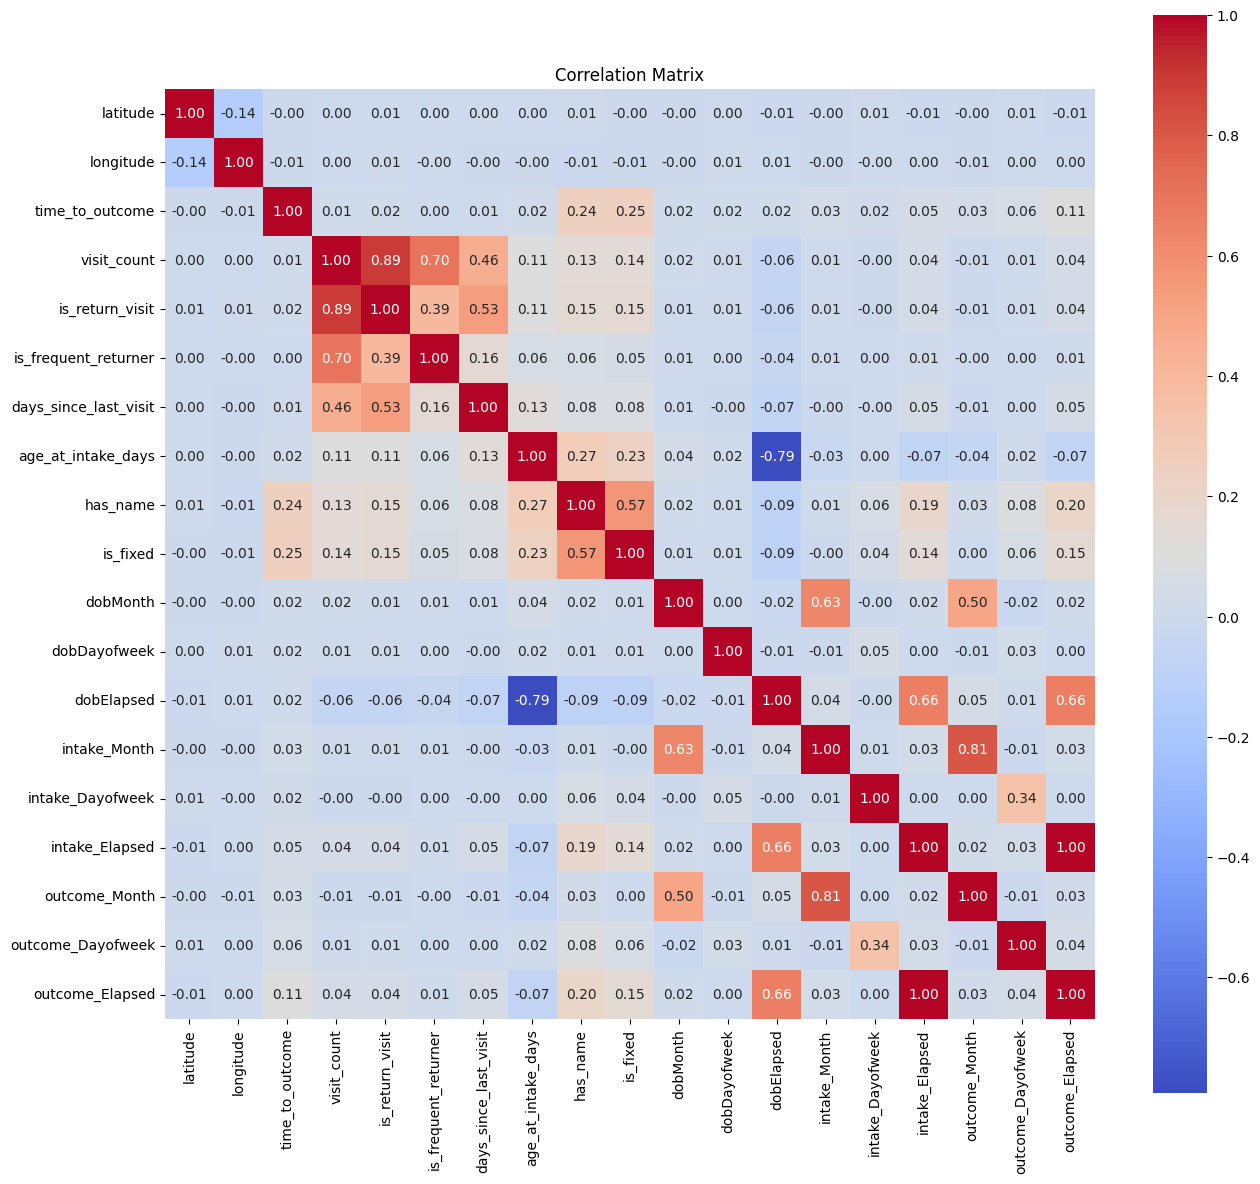

In [55]:
# Compute the correlation matrix (only numeric columns)
corr = df.select_dtypes(include='number').corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(15, 14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31334 entries, 14992 to 20462
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   animal_type            31334 non-null  object         
 1   primary_color          31334 non-null  object         
 2   secondary_color        31334 non-null  object         
 3   sex                    31334 non-null  object         
 4   intake_cond            31334 non-null  object         
 5   intake_type            31334 non-null  object         
 6   intake_subtype         31334 non-null  object         
 7   jurisdiction           31333 non-null  object         
 8   outcome_type           31334 non-null  object         
 9   outcome_subtype        27947 non-null  object         
 10  latitude               31334 non-null  float64        
 11  longitude              31334 non-null  float64        
 12  outcome_is_dead        31334 non-null  bool    

# Isolation forest

## Feature engineering

In [57]:
df['time_to_outcome_days'] = df['time_to_outcome'].dt.total_seconds() / (24 * 3600)

## Categorical columns

In [58]:
# Define categorical variables for encoding
categorical_columns = ['animal_type', 'primary_color', 'secondary_color', 'sex', 
                      'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction',
                      'outcome_type', 'previous_outcome_type']


In [59]:
# Label encode categorical variables
label_encoders = {}
df_encoded = df.copy()

In [60]:
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

## Selecting features for isolation forest

In [61]:
feature_columns = [
    # Encoded categorical features
    'animal_type_encoded', 'primary_color_encoded', 'secondary_color_encoded', 
    'sex_encoded', 'intake_cond_encoded', 'intake_type_encoded', 
    'intake_subtype_encoded', 'jurisdiction_encoded', 'outcome_type_encoded', 
    'previous_outcome_type_encoded',
    # Numerical features
    'latitude', 'longitude', 'outcome_is_dead', 'visit_count', 'is_return_visit',
    'is_frequent_returner', 'days_since_last_visit', 'age_at_intake_days',
    'has_name', 'is_fixed', 'dobMonth', 'dobDayofweek', 'dobElapsed',
    'intake_Month', 'intake_Dayofweek', 'intake_Elapsed', 'outcome_Month',
    'outcome_Dayofweek', 'outcome_Elapsed', 'time_to_outcome_days'
]

In [62]:
# Create feature matrix
X = df_encoded[feature_columns].copy()

In [63]:
# Convert boolean to int
X['outcome_is_dead'] = X['outcome_is_dead'].astype(int)

Feature matrix shape: (31209, 30)
Features used: 30

Isolation Forest Results:
Total samples: 31209
Outliers detected: 313 (1.00%)
Inliers: 30896 (99.00%)


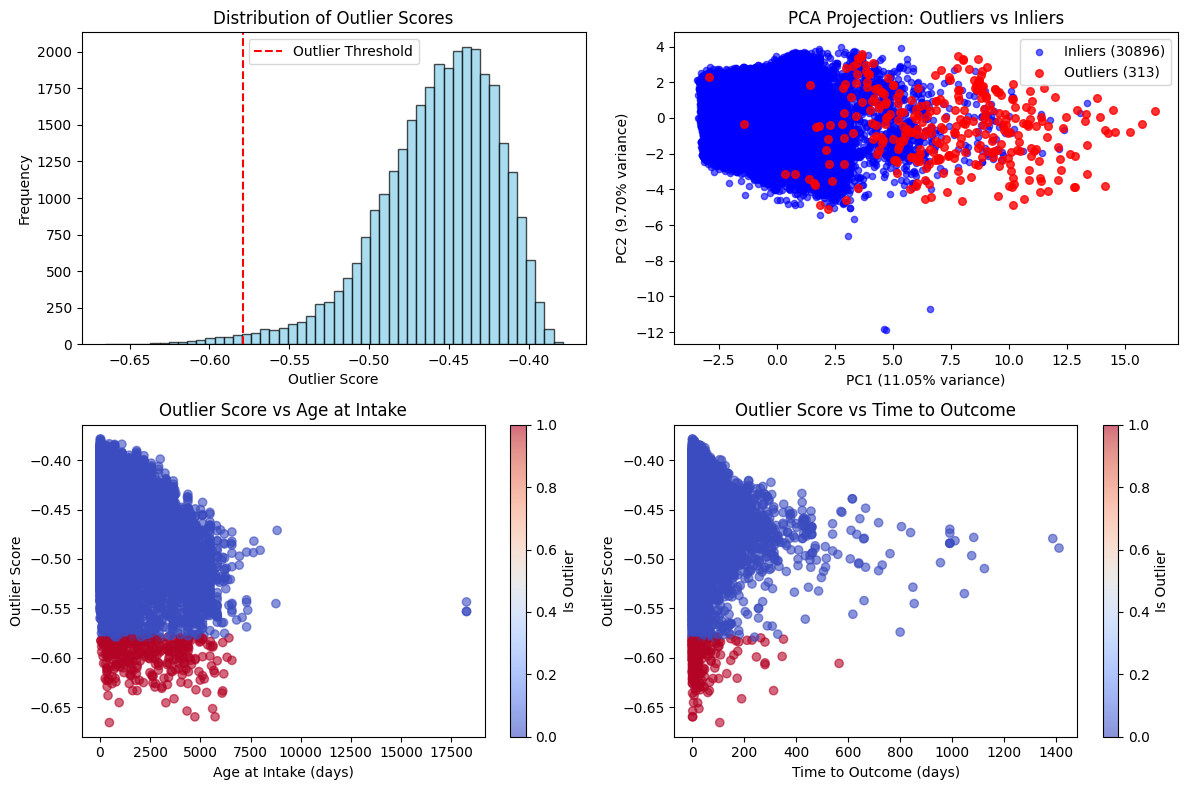


Top 10 Outliers (lowest scores):
      animal_type     outcome_type  age_at_intake_days  time_to_outcome_days  visit_count  outlier_score
9933          DOG         ADOPTION                 469                 105.0            3      -0.665709
26553         DOG  RETURN TO OWNER                4728                   1.0            3      -0.659935
19915         DOG  RETURN TO OWNER                5735                   0.0            4      -0.659872
23471         CAT       EUTHANASIA                4337                   1.0            3      -0.654002
6731          DOG             DIED                5612                  25.0            2      -0.651636
19276         CAT       EUTHANASIA                3283                  20.0            3      -0.645721
31184         DOG  RETURN TO OWNER                 957                   4.0            3      -0.645466
21778         DOG       EUTHANASIA                3691                 189.0            2      -0.641618
24592         DOG    

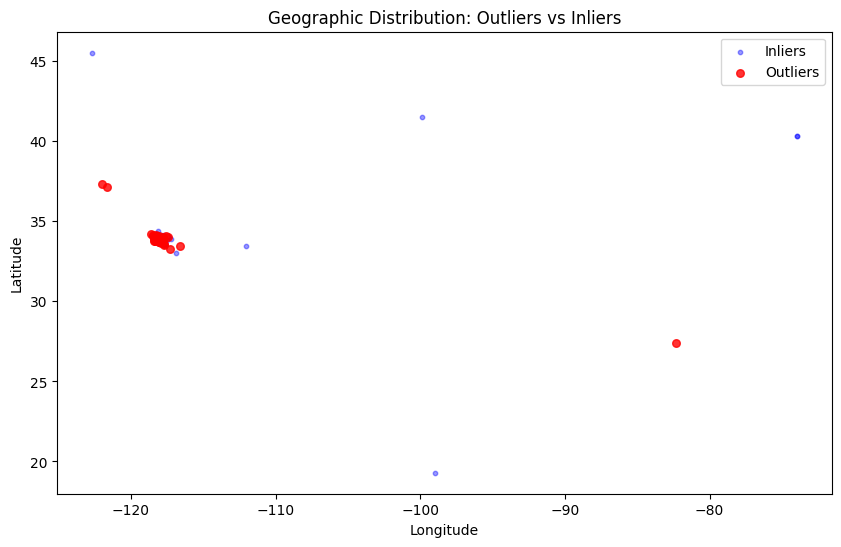


Isolation Forest completed!
Outlier detection results added to dataframe as 'is_outlier' and 'outlier_score' columns


In [65]:
print("Feature matrix shape:", X.shape)
print("Features used:", len(feature_columns))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Isolation Forest
# contamination parameter: expected proportion of outliers (adjust as needed)
isolation_forest = IsolationForest(
    contamination=0.01,  # Expect 5% outliers
    random_state=42,
    n_estimators=100
)

# Fit and predict
outlier_labels = isolation_forest.fit_predict(X_scaled)
outlier_scores = isolation_forest.score_samples(X_scaled)

# Add results to dataframe
df_encoded['outlier_label'] = outlier_labels
df_encoded['outlier_score'] = outlier_scores
df_encoded['is_outlier'] = (outlier_labels == -1)

# Print results summary
n_outliers = sum(outlier_labels == -1)
n_inliers = sum(outlier_labels == 1)
outlier_percentage = (n_outliers / len(df_encoded)) * 100

print(f"\nIsolation Forest Results:")
print(f"Total samples: {len(df_encoded)}")
print(f"Outliers detected: {n_outliers} ({outlier_percentage:.2f}%)")
print(f"Inliers: {n_inliers} ({100-outlier_percentage:.2f}%)")

# Visualization 1: Outlier Score Distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(outlier_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=outlier_scores[outlier_labels == -1].max(), color='red', 
           linestyle='--', label=f'Outlier Threshold')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('Distribution of Outlier Scores')
plt.legend()

# Visualization 2: PCA projection for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.subplot(2, 2, 2)
inlier_mask = outlier_labels == 1
outlier_mask = outlier_labels == -1

plt.scatter(X_pca[inlier_mask, 0], X_pca[inlier_mask, 1], 
           c='blue', alpha=0.6, s=20, label=f'Inliers ({n_inliers})')
plt.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1], 
           c='red', alpha=0.8, s=30, label=f'Outliers ({n_outliers})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Projection: Outliers vs Inliers')
plt.legend()

# Visualization 3: Outlier scores vs some key features
plt.subplot(2, 2, 3)
plt.scatter(df_encoded['age_at_intake_days'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Age at Intake (days)')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Age at Intake')
plt.colorbar(label='Is Outlier')

plt.subplot(2, 2, 4)
plt.scatter(df_encoded['time_to_outcome_days'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Time to Outcome (days)')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Time to Outcome')
plt.colorbar(label='Is Outlier')

plt.tight_layout()
plt.show()

# Additional analysis: Top outliers
print("\nTop 10 Outliers (lowest scores):")
top_outliers = df_encoded[df_encoded['is_outlier']].nsmallest(10, 'outlier_score')
print(top_outliers[['animal_type', 'outcome_type', 'age_at_intake_days', 
                   'time_to_outcome_days', 'visit_count', 'outlier_score']].to_string())

# Feature importance analysis (based on outlier characteristics)
print("\nOutlier vs Inlier Comparison (mean values):")
comparison_features = ['age_at_intake_days', 'time_to_outcome_days', 'visit_count', 
                      'days_since_last_visit', 'is_frequent_returner']

outlier_means = df_encoded[df_encoded['is_outlier']][comparison_features].mean()
inlier_means = df_encoded[~df_encoded['is_outlier']][comparison_features].mean()

comparison_df = pd.DataFrame({
    'Outliers': outlier_means,
    'Inliers': inlier_means,
    'Difference': outlier_means - inlier_means
})
print(comparison_df.round(2))

# Categorical feature analysis for outliers
print("\nCategorical Feature Distribution in Outliers:")
categorical_analysis = ['animal_type', 'outcome_type', 'intake_type']
for feature in categorical_analysis:
    print(f"\n{feature} distribution in outliers:")
    outlier_dist = df_encoded[df_encoded['is_outlier']][feature].value_counts().head()
    total_dist = df_encoded[feature].value_counts().head()
    print("Outliers:", outlier_dist.to_dict())
    print("Overall:", total_dist.to_dict())

# Geographic outliers visualization
plt.figure(figsize=(10, 6))
plt.scatter(df_encoded[~df_encoded['is_outlier']]['longitude'], 
           df_encoded[~df_encoded['is_outlier']]['latitude'], 
           c='blue', alpha=0.4, s=10, label='Inliers')
plt.scatter(df_encoded[df_encoded['is_outlier']]['longitude'], 
           df_encoded[df_encoded['is_outlier']]['latitude'], 
           c='red', alpha=0.8, s=30, label='Outliers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution: Outliers vs Inliers')
plt.legend()
plt.show()

print(f"\nIsolation Forest completed!")
print(f"Outlier detection results added to dataframe as 'is_outlier' and 'outlier_score' columns")

# Clustering

For clustering, let's try 3 algorithms:
1. K-Prototype clustering: Great for hybrid data with categorical and numerical features
2. Hierarchical clustering with Gower distance: No need for encoding categorical features
3. DBSCAN with gower distance: Density based clustering option

## Preprocessing

In [57]:
# Data preprocessing - Drop outcome-related features
features_to_drop = [
    'outcome_type', 'outcome_subtype', 'outcome_is_dead', 
    'time_to_outcome', 'time_to_outcome_days',
    'outcome_Month', 'outcome_Dayofweek', 'outcome_Elapsed'
]

# Keep all other features
df_cluster = df.drop(columns=[col for col in features_to_drop if col in df.columns], errors='ignore')

In [58]:
df_cluster = df_cluster[df_cluster['jurisdiction'].notna()]

In [59]:
# Identify categorical and numerical columns
categorical_cols = df_cluster.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_cluster.select_dtypes(include=['number', 'bool']).columns.tolist()

print(f"\nCategorical features ({len(categorical_cols)}):", categorical_cols)
print(f"Numerical features ({len(numerical_cols)}):", numerical_cols)

# Prepare data for clustering
X_cluster = df_cluster.copy()

# Convert boolean columns to int for consistency
for col in X_cluster.columns:
    if X_cluster[col].dtype == 'bool':
        X_cluster[col] = X_cluster[col].astype(int)

# Update numerical columns list after boolean conversion
numerical_cols = X_cluster.select_dtypes(include=['number']).columns.tolist()

print(f"Final numerical features: {len(numerical_cols)}")
print(f"Final categorical features: {len(categorical_cols)}")


Categorical features (9): ['animal_type', 'primary_color', 'secondary_color', 'sex', 'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction', 'previous_outcome_type']
Numerical features (15): ['latitude', 'longitude', 'visit_count', 'is_return_visit', 'is_frequent_returner', 'days_since_last_visit', 'age_at_intake_days', 'has_name', 'is_fixed', 'dobMonth', 'dobDayofweek', 'dobElapsed', 'intake_Month', 'intake_Dayofweek', 'intake_Elapsed']
Final numerical features: 15
Final categorical features: 9


## K-Prototype clustering

In [60]:
# Test different numbers of clusters for K-Prototypes
k_range = range(2, 11)
kproto_silhouette_scores = []
kproto_costs = []
kproto_models = {}

# Determine categorical feature indices for K-Prototypes
categorical_indices = [X_cluster.columns.get_loc(col) for col in categorical_cols]

print("Testing K-Prototypes with different cluster sizes...")
for k in k_range:
    print(f"Testing K={k}...")
    
    # Fit K-Prototypes
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    cluster_labels = kproto.fit_predict(X_cluster.values, categorical=categorical_indices)
    
    # Calculate silhouette score using Gower distance
    gower_dist = gower.gower_matrix(X_cluster)
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric='precomputed')
    
    kproto_silhouette_scores.append(silhouette_avg)
    kproto_costs.append(kproto.cost_)
    kproto_models[k] = (kproto, cluster_labels)
    
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}, Cost = {kproto.cost_:.2f}")

# Find optimal K for K-Prototypes
optimal_k_kproto = k_range[np.argmax(kproto_silhouette_scores)]
best_kproto_model, best_kproto_labels = kproto_models[optimal_k_kproto]

print(f"\nOptimal K for K-Prototypes: {optimal_k_kproto}")
print(f"Best Silhouette Score: {max(kproto_silhouette_scores):.4f}")

Testing K-Prototypes with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.0504, Cost = 297694127973519917056.00
Testing K=3...
K=3: Silhouette Score = 0.0262, Cost = 171883260683769315328.00
Testing K=4...
K=4: Silhouette Score = 0.0129, Cost = 124116322899236421632.00
Testing K=5...
K=5: Silhouette Score = 0.0093, Cost = 100088969631950225408.00
Testing K=6...
K=6: Silhouette Score = 0.0033, Cost = 82451702718760501248.00
Testing K=7...
K=7: Silhouette Score = -0.0068, Cost = 67823403832367865856.00
Testing K=8...
K=8: Silhouette Score = -0.0089, Cost = 60016088037005713408.00
Testing K=9...
K=9: Silhouette Score = -0.0109, Cost = 53082249864486395904.00
Testing K=10...
K=10: Silhouette Score = -0.0155, Cost = 47151692224369573888.00

Optimal K for K-Prototypes: 2
Best Silhouette Score: 0.0504


## Gower distance matrix calculation

In [61]:
print("\n" + "="*60)
print("COMPUTING GOWER DISTANCE MATRIX")
print("="*60)

print("Computing Gower distance matrix...")
# Sample data if too large (Gower distance computation can be memory intensive)
if len(X_cluster) > 5000:
    print(f"Sampling 5000 rows from {len(X_cluster)} for distance computation...")
    sample_indices = np.random.choice(len(X_cluster), 5000, replace=False)
    X_sample = X_cluster.iloc[sample_indices]
    gower_dist_matrix = gower.gower_matrix(X_sample)
else:
    X_sample = X_cluster
    sample_indices = np.arange(len(X_cluster))
    gower_dist_matrix = gower.gower_matrix(X_sample)

print(f"Gower distance matrix shape: {gower_dist_matrix.shape}")



COMPUTING GOWER DISTANCE MATRIX
Computing Gower distance matrix...
Sampling 5000 rows from 31333 for distance computation...
Gower distance matrix shape: (5000, 5000)


## DBSCAN

In [62]:
print("\n" + "="*60)
print("DBSCAN WITH GOWER DISTANCE")
print("="*60)

# Test different epsilon values for DBSCAN
epsilon_range = np.arange(0.1, 1.0, 0.1)
dbscan_silhouette_scores = []
dbscan_n_clusters = []
dbscan_models = {}

print("Testing DBSCAN with different epsilon values...")
for eps in epsilon_range:
    print(f"Testing eps={eps:.2f}...")
    
    # Fit DBSCAN with precomputed Gower distance
    dbscan = DBSCAN(eps=eps, min_samples=5, metric='precomputed')
    cluster_labels = dbscan.fit_predict(gower_dist_matrix)
    
    # Count clusters (excluding noise points labeled as -1)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    dbscan_n_clusters.append(n_clusters)
    
    # Calculate silhouette score (only if we have more than 1 cluster)
    if n_clusters > 1:
        # Remove noise points for silhouette calculation
        mask = cluster_labels != -1
        if np.sum(mask) > 1:
            silhouette_avg = silhouette_score(gower_dist_matrix[mask][:, mask], 
                                            cluster_labels[mask], metric='precomputed')
        else:
            silhouette_avg = -1
    else:
        silhouette_avg = -1
    
    dbscan_silhouette_scores.append(silhouette_avg)
    dbscan_models[eps] = (dbscan, cluster_labels)
    
    print(f"eps={eps:.2f}: Clusters = {n_clusters}, Noise = {n_noise}, Silhouette = {silhouette_avg:.4f}")

# Find optimal epsilon for DBSCAN
valid_scores = [score for score in dbscan_silhouette_scores if score > -1]
if valid_scores:
    optimal_eps_idx = np.argmax(dbscan_silhouette_scores)
    optimal_eps = epsilon_range[optimal_eps_idx]
    best_dbscan_model, best_dbscan_labels = dbscan_models[optimal_eps]
    
    print(f"\nOptimal epsilon for DBSCAN: {optimal_eps:.2f}")
    print(f"Best Silhouette Score: {max(dbscan_silhouette_scores):.4f}")
    print(f"Number of clusters: {dbscan_n_clusters[optimal_eps_idx]}")
else:
    print("No valid DBSCAN clustering found with given epsilon range")


DBSCAN WITH GOWER DISTANCE
Testing DBSCAN with different epsilon values...
Testing eps=0.10...
eps=0.10: Clusters = 4, Noise = 1172, Silhouette = -0.0735
Testing eps=0.20...
eps=0.20: Clusters = 1, Noise = 22, Silhouette = -1.0000
Testing eps=0.30...
eps=0.30: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.40...
eps=0.40: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.50...
eps=0.50: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.60...
eps=0.60: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.70...
eps=0.70: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.80...
eps=0.80: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.90...
eps=0.90: Clusters = 1, Noise = 0, Silhouette = -1.0000

Optimal epsilon for DBSCAN: 0.10
Best Silhouette Score: -0.0735
Number of clusters: 4


## Hierarchical clustering

In [64]:
print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING WITH GOWER DISTANCE")
print("="*60)

# Perform hierarchical clustering with different numbers of clusters
hierarchical_silhouette_scores = []
hierarchical_models = {}

print("Testing Hierarchical clustering with different cluster sizes...")
for k in k_range:
    print(f"Testing K={k}...")
    
    # Fit Agglomerative Clustering with precomputed distance
    hierarchical = AgglomerativeClustering(n_clusters=k, metric='euclidean', 
                                         linkage='average')
    cluster_labels = hierarchical.fit_predict(gower_dist_matrix)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(gower_dist_matrix, cluster_labels, metric='precomputed')
    
    hierarchical_silhouette_scores.append(silhouette_avg)
    hierarchical_models[k] = (hierarchical, cluster_labels)
    
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal K for Hierarchical clustering
optimal_k_hierarchical = k_range[np.argmax(hierarchical_silhouette_scores)]
best_hierarchical_model, best_hierarchical_labels = hierarchical_models[optimal_k_hierarchical]

print(f"\nOptimal K for Hierarchical: {optimal_k_hierarchical}")
print(f"Best Silhouette Score: {max(hierarchical_silhouette_scores):.4f}")


HIERARCHICAL CLUSTERING WITH GOWER DISTANCE
Testing Hierarchical clustering with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.2666
Testing K=3...
K=3: Silhouette Score = 0.2126
Testing K=4...
K=4: Silhouette Score = 0.2085
Testing K=5...
K=5: Silhouette Score = 0.2048
Testing K=6...
K=6: Silhouette Score = 0.1678
Testing K=7...
K=7: Silhouette Score = 0.1401
Testing K=8...
K=8: Silhouette Score = 0.1390
Testing K=9...
K=9: Silhouette Score = 0.1314
Testing K=10...
K=10: Silhouette Score = 0.1092

Optimal K for Hierarchical: 2
Best Silhouette Score: 0.2666


## Visual insights from clustering


CREATING VISUALIZATIONS


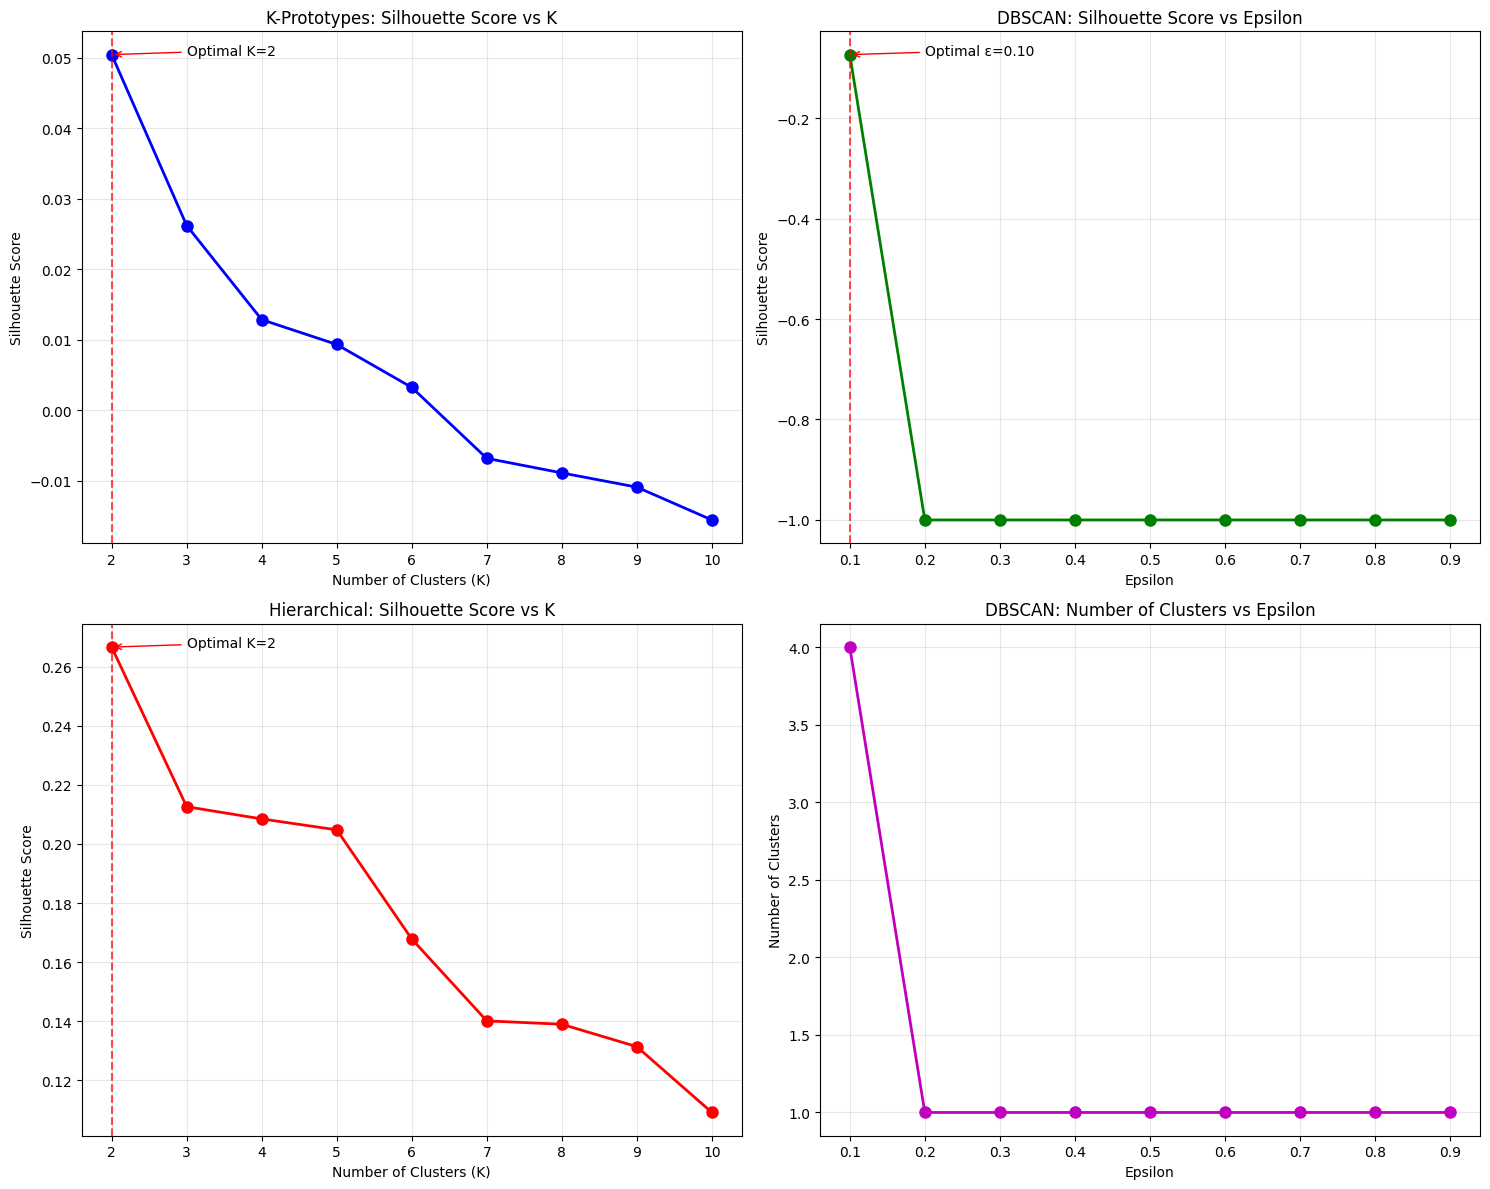

Creating PCA visualizations...


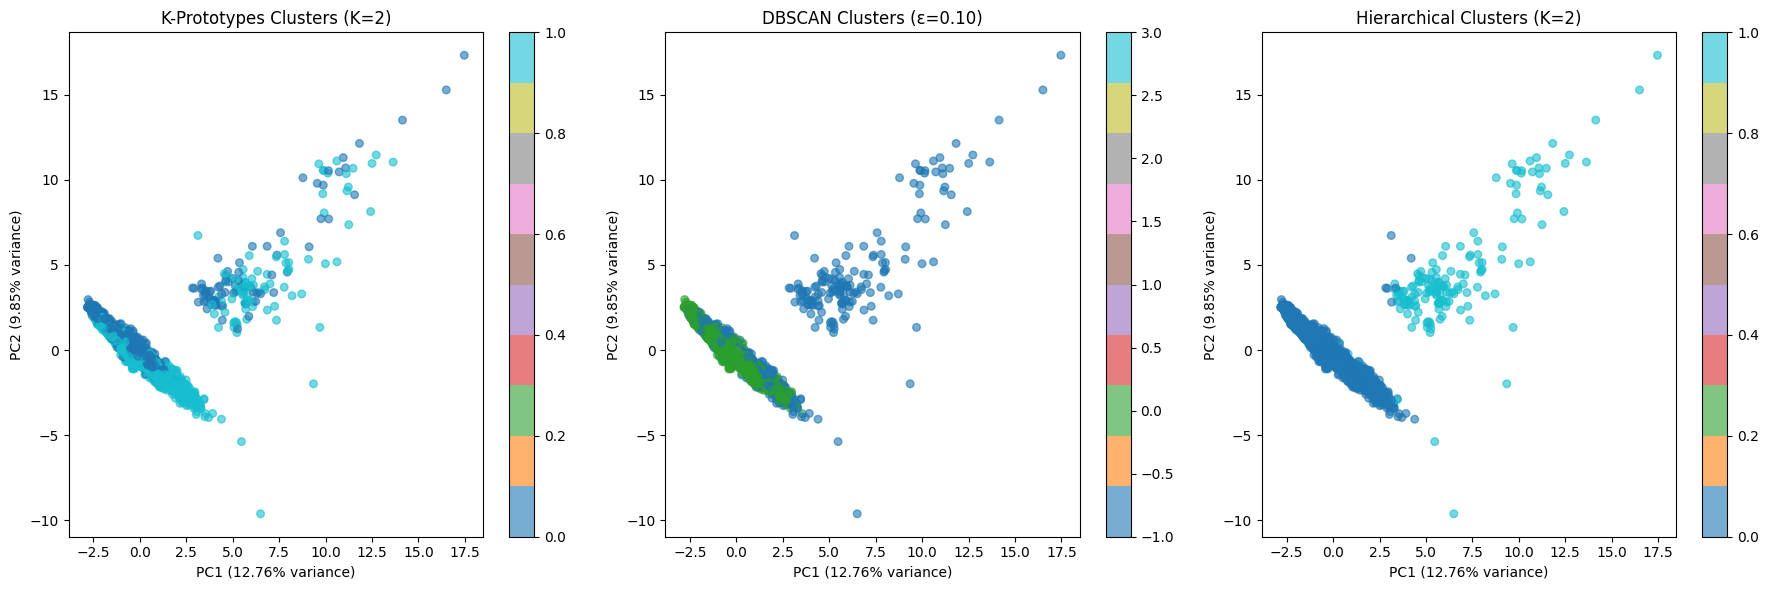


CLUSTER CHARACTERISTICS ANALYSIS

K-PROTOTYPES CLUSTER CHARACTERISTICS:
--------------------------------------------------

Cluster 0 (n=2465):
Top categorical characteristics:
  animal_type: CAT (50.5%)
  primary_color: BLACK (24.4%)
  secondary_color: None (53.7%)
  sex: Male (40.0%)
  intake_cond: NORMAL (39.4%)
Numerical characteristics:
  age_at_intake_days: 341.56
  visit_count: 1.04
  latitude: 33.81
  longitude: -118.16

Cluster 1 (n=2535):
Top categorical characteristics:
  animal_type: CAT (42.9%)
  primary_color: BLACK (26.0%)
  secondary_color: None (50.4%)
  sex: Male (43.2%)
  intake_cond: NORMAL (54.2%)
Numerical characteristics:
  age_at_intake_days: 1145.06
  visit_count: 1.04
  latitude: 33.82
  longitude: -118.16

ALGORITHM PERFORMANCE SUMMARY
   Algorithm Optimal_Params  Silhouette_Score  N_Clusters
K-Prototypes            K=2          0.050443           2
Hierarchical            K=2          0.266601           2
      DBSCAN         ε=0.10         -0.073542       

In [65]:
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# 1. Silhouette Score Comparison Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# K-Prototypes Silhouette Scores
axes[0, 0].plot(k_range, kproto_silhouette_scores, 'bo-', linewidth=2, markersize=8)
axes[0, 0].axvline(x=optimal_k_kproto, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('Number of Clusters (K)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('K-Prototypes: Silhouette Score vs K')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].annotate(f'Optimal K={optimal_k_kproto}', 
                   xy=(optimal_k_kproto, kproto_silhouette_scores[optimal_k_kproto-2]), 
                   xytext=(optimal_k_kproto+1, kproto_silhouette_scores[optimal_k_kproto-2]),
                   arrowprops=dict(arrowstyle='->', color='red'))

# DBSCAN Silhouette Scores
axes[0, 1].plot(epsilon_range, dbscan_silhouette_scores, 'go-', linewidth=2, markersize=8)
if valid_scores:
    axes[0, 1].axvline(x=optimal_eps, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].annotate(f'Optimal ε={optimal_eps:.2f}', 
                       xy=(optimal_eps, max(dbscan_silhouette_scores)), 
                       xytext=(optimal_eps+0.1, max(dbscan_silhouette_scores)),
                       arrowprops=dict(arrowstyle='->', color='red'))
axes[0, 1].set_xlabel('Epsilon')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('DBSCAN: Silhouette Score vs Epsilon')
axes[0, 1].grid(True, alpha=0.3)

# Hierarchical Silhouette Scores
axes[1, 0].plot(k_range, hierarchical_silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].axvline(x=optimal_k_hierarchical, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel('Number of Clusters (K)')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].set_title('Hierarchical: Silhouette Score vs K')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].annotate(f'Optimal K={optimal_k_hierarchical}', 
                   xy=(optimal_k_hierarchical, hierarchical_silhouette_scores[optimal_k_hierarchical-2]), 
                   xytext=(optimal_k_hierarchical+1, hierarchical_silhouette_scores[optimal_k_hierarchical-2]),
                   arrowprops=dict(arrowstyle='->', color='red'))

# DBSCAN Number of Clusters vs Epsilon
axes[1, 1].plot(epsilon_range, dbscan_n_clusters, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Epsilon')
axes[1, 1].set_ylabel('Number of Clusters')
axes[1, 1].set_title('DBSCAN: Number of Clusters vs Epsilon')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. PCA Visualization of Clusters
print("Creating PCA visualizations...")

# Prepare data for PCA (encode categorical variables for PCA)
from sklearn.preprocessing import LabelEncoder
X_pca = X_sample.copy()
label_encoders = {}

for col in categorical_cols:
    if col in X_pca.columns:
        le = LabelEncoder()
        X_pca[col] = le.fit_transform(X_pca[col].astype(str))
        label_encoders[col] = le

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# Create cluster visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Prototypes visualization (sample the labels to match PCA data)
if len(X_cluster) > 5000:
    kproto_labels_sample = best_kproto_labels[sample_indices]
else:
    kproto_labels_sample = best_kproto_labels

scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=kproto_labels_sample, cmap='tab10', alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'K-Prototypes Clusters (K={optimal_k_kproto})')
plt.colorbar(scatter1, ax=axes[0])

# DBSCAN visualization
if valid_scores:
    scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                              c=best_dbscan_labels, cmap='tab10', alpha=0.6, s=30)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    axes[1].set_title(f'DBSCAN Clusters (ε={optimal_eps:.2f})')
    plt.colorbar(scatter2, ax=axes[1])

# Hierarchical visualization
scatter3 = axes[2].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=best_hierarchical_labels, cmap='tab10', alpha=0.6, s=30)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[2].set_title(f'Hierarchical Clusters (K={optimal_k_hierarchical})')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

# 3. Cluster Characteristics Analysis
print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("="*60)

# Add cluster labels to original dataframe for analysis
df_analysis = df_cluster.iloc[sample_indices].copy()
df_analysis['KPrototypes_Cluster'] = kproto_labels_sample
df_analysis['Hierarchical_Cluster'] = best_hierarchical_labels

if valid_scores:
    df_analysis['DBSCAN_Cluster'] = best_dbscan_labels

# Analyze K-Prototypes clusters
print("\nK-PROTOTYPES CLUSTER CHARACTERISTICS:")
print("-" * 50)

for cluster_id in sorted(df_analysis['KPrototypes_Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['KPrototypes_Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    # Categorical feature analysis
    print("Top categorical characteristics:")
    for cat_col in categorical_cols[:5]:  # Show top 5 categorical features
        if cat_col in cluster_data.columns:
            top_category = cluster_data[cat_col].mode().iloc[0]
            percentage = (cluster_data[cat_col] == top_category).mean() * 100
            print(f"  {cat_col}: {top_category} ({percentage:.1f}%)")
    
    # Numerical feature analysis
    print("Numerical characteristics:")
    for num_col in ['age_at_intake_days', 'visit_count', 'latitude', 'longitude'][:4]:
        if num_col in cluster_data.columns:
            mean_val = cluster_data[num_col].mean()
            print(f"  {num_col}: {mean_val:.2f}")

# Summary comparison
print("\n" + "="*60)
print("ALGORITHM PERFORMANCE SUMMARY")
print("="*60)

summary_data = {
    'Algorithm': ['K-Prototypes', 'Hierarchical', 'DBSCAN'],
    'Optimal_Params': [f'K={optimal_k_kproto}', f'K={optimal_k_hierarchical}', 
                      f'ε={optimal_eps:.2f}' if valid_scores else 'N/A'],
    'Silhouette_Score': [max(kproto_silhouette_scores), 
                        max(hierarchical_silhouette_scores),
                        max(dbscan_silhouette_scores) if valid_scores else 'N/A'],
    'N_Clusters': [optimal_k_kproto, optimal_k_hierarchical,
                  dbscan_n_clusters[optimal_eps_idx] if valid_scores else 'N/A']
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\nClustering analysis completed!")
print("Best performing algorithm:", summary_df.loc[summary_df['Silhouette_Score'].idxmax(), 'Algorithm'] 
      if valid_scores else "K-Prototypes or Hierarchical")

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31334 entries, 14992 to 20462
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   animal_type            31334 non-null  object         
 1   primary_color          31334 non-null  object         
 2   secondary_color        31334 non-null  object         
 3   sex                    31334 non-null  object         
 4   intake_cond            31334 non-null  object         
 5   intake_type            31334 non-null  object         
 6   intake_subtype         31334 non-null  object         
 7   jurisdiction           31333 non-null  object         
 8   outcome_type           31334 non-null  object         
 9   outcome_subtype        27947 non-null  object         
 10  latitude               31334 non-null  float64        
 11  longitude              31334 non-null  float64        
 12  outcome_is_dead        31334 non-null  bool    

In [67]:
df.head()

,animal_type,primary_color,secondary_color,sex,intake_cond,intake_type,intake_subtype,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,is_fixed,dobMonth,dobDayofweek,dobElapsed,intake_Month,intake_Dayofweek,intake_Elapsed,outcome_Month,outcome_Dayofweek,outcome_Elapsed
14992,DOG,TRICOLOR,None,Female,AGED,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1 days,1,0,0,-1.0,First Visit,5408,1,1,8,0,1.156118e+09,6,4,1.623370e+09,6,5,1.623456e+09
13421,DOG,WHITE,None,Female,NORMAL,CONFISCATE,POLICE,LONG BEACH,RETURN TO OWNER,FRE RID HM,33.757655,-118.142195,False,1 days,1,0,0,-1.0,First Visit,3127,1,1,12,1,1.228781e+09,7,6,1.498954e+09,7,0,1.499040e+09
3401,OTHER,GRAY,None,Unknown,ILL MODERATETE,WILDLIFE,FIELD,LONG BEACH,RESCUE,IBR,33.782031,-118.122403,False,1 days,1,0,0,-1.0,First Visit,42,0,0,4,0,1.649030e+09,5,0,1.652659e+09,5,1,1.652746e+09
13982,DOG,CREAM,None,Male,NORMAL,STRAY,OTC,LONG BEACH,RETURN TO OWNER,WALKIN,33.806222,-118.195897,False,2 days,1,0,0,-1.0,First Visit,5513,1,1,4,0,1.177286e+09,5,4,1.653610e+09,5,6,1.653782e+09
16153,DOG,TAN,WHITE,Female,NORMAL,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,MICROCHIP,33.865972,-118.192637,False,8 days,1,0,0,-1.0,First Visit,4256,1,1,5,4,1.116547e+09,1,4,1.484266e+09,1,5,1.484957e+09
